<a href="https://colab.research.google.com/github/mviganalk/IEP_NEXT_Credit-Card-Approval/blob/main/IEP_Credit_Card_Approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1). Introduction
This notebook will use two datasets to predict if a customer would be approved for a credit card. The first dataset, application_record details information about each customer that might impact how likely they are to be approved for a credit card. The second dataset, credit_record, details if each customer has paid off their current credit card, or how many days past due they are. The two datasets are connected by a unique ID for each customer.

#2). Importing File

In [1]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.9 MB/s eta 0:00:00


In [2]:
#import needed libraries
import gdown #Untuk download data dr GDrive
import pandas as pd # Load tabel/CSV/Excel/GSheet...
import numpy as np # Numpy array
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier

In [3]:
# Let's download the data files using gdown = credit dataset
url = "https://drive.google.com/file/d/1rzIkq4MKdZPZ_eB1VGBQzwqG7XuzNayK/view?usp=sharing"
output = "credit_record.csv"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1rzIkq4MKdZPZ_eB1VGBQzwqG7XuzNayK
To: /content/credit_record.csv
100%|██████████| 15.4M/15.4M [00:00<00:00, 66.0MB/s]


'credit_record.csv'

In [4]:
# Let's download the data files using gdown = application dataset
url = "https://drive.google.com/file/d/1-uRqrTF-j52XnMrOZrbgENa7CEvJmaTi/view?usp=sharing"
output = "application_record.csv"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1-uRqrTF-j52XnMrOZrbgENa7CEvJmaTi
To: /content/application_record.csv
100%|██████████| 54.3M/54.3M [00:00<00:00, 115MB/s]


'application_record.csv'

#3). Prepare Data

In [5]:
# To import data from CSV file, we can use `pd.read_csv('filename.csv')` function
# Let's import it and store it as "df" variable
# df_credit
df_credit = pd.read_csv('/content/credit_record.csv')
df_credit

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


**Data Dictionary  df_credit**
1. MONTHS_BALANCE
* The month of the extracted data is the starting point, backwards,
* 0 is the current month,
* -1 is the previous month, and so on
2. STATUS
* 0: 1-29 days past due
* 1: 30-59 days past due
* 2: 60-89 days overdue
* 3: 90-119 days overdue
* 4: 120-149 days overdue
* 5: Overdue or bad debts, write-offs for more than 150 days
* C: paid off that month
* X: No loan for the month

In [6]:
# To import data from CSV file, we can use `pd.read_csv('filename.csv')` function
# Let's import it and store it as "df" variable
# df_application
df_application = pd.read_csv('/content/application_record.csv')
df_application

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


**Data Dictionary  df_application**
1. DAYS_BIRTH
* Count backwards from current day (0), -1 means yesterday
2. DAYS_EMPLOYED
* Count backwards from current day(0). If positive, it means the person currently unemployed.

In [7]:
df_credit.info()
df_credit.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

In [8]:
df_application.info()
df_application.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

##APPLICATION DATASET

###Cleaning Data
### When comparing total values to unique values, we see that there are 47 ID's that are not unique in the df_application dataframe. This is a low amount, but could complicate things down the line. Lets just remove ID values that are not unique.

In [9]:
#For each set of duplicate ID's drop both of them
df_application = df_application.drop_duplicates(subset = 'ID', keep = False)
df_application.info()
df_application.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438463 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438463 non-null  int64  
 1   CODE_GENDER          438463 non-null  object 
 2   FLAG_OWN_CAR         438463 non-null  object 
 3   FLAG_OWN_REALTY      438463 non-null  object 
 4   CNT_CHILDREN         438463 non-null  int64  
 5   AMT_INCOME_TOTAL     438463 non-null  float64
 6   NAME_INCOME_TYPE     438463 non-null  object 
 7   NAME_EDUCATION_TYPE  438463 non-null  object 
 8   NAME_FAMILY_STATUS   438463 non-null  object 
 9   NAME_HOUSING_TYPE    438463 non-null  object 
 10  DAYS_BIRTH           438463 non-null  int64  
 11  DAYS_EMPLOYED        438463 non-null  int64  
 12  FLAG_MOBIL           438463 non-null  int64  
 13  FLAG_WORK_PHONE      438463 non-null  int64  
 14  FLAG_PHONE           438463 non-null  int64  
 15  FLAG_EMAIL       

ID                     438463
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [10]:
#Rename Application Dataset
df_application = df_application.rename(columns={
    'CODE_GENDER':'GENDER',
    'FLAG_OWN_CAR':'HAS_OWN_CAR',
    'FLAG_OWN_REALTY':'HAS_A_PROPERTY',
    'AMT_INCOME_TOTAL':'ANNUAL_INCOME',
    'NAME_INCOME_TYPE':'INCOME_CATEGORY',
    'NAME_EDUCATION_TYPE':'EDUCATION_LEVEL',
    'NAME_FAMILY_STATUS':'MARITAL_STATUS',
    'NAME_HOUSING_TYPE':'WAY_OF_LIVING',
    'DAYS_BIRTH':'AGE',
    'DAYS_EMPLOYED': 'EMPLOYMENT_LENGTH',
    'FLAG_MOBIL': 'HAS_A_MOBILE_PHONE',
    'FLAG_WORK_PHONE': 'HAS_A_WORK_PHONE',
    'FLAG_PHONE': 'HAS_A_PHONE',
    'FLAG_EMAIL': 'HAS_A_EMAIL',
    'OCCUPATION_TYPE': 'JOB_TITTLE',
    'CNT_FAM_MEMBERS': 'FAMILY_MEMBER_COUNT'}
)

In [11]:

#Drop null, and has a mobile phone (one value)
df_application.drop(columns=['HAS_A_MOBILE_PHONE'], inplace=True)
df_application.dropna(inplace=True)

#Change minus Days into Days
df_application['AGE'] = df_application.AGE*(-1)

#Pensioneer has an positive employemnt length
df_application['EMPLOYMENT_LENGTH'] = np.where(df_application.EMPLOYMENT_LENGTH>0,0,df_application.EMPLOYMENT_LENGTH*(-1))

In [12]:
#df_application copy and cleaning
application_df = df_application.copy()
#we change AGE to (Years Old) and EMPLOYMENT_LENGTH to (Year)
application_df['AGE'] = application_df.AGE//360
application_df['EMPLOYMENT_LENGTH'] = application_df.EMPLOYMENT_LENGTH//360
#we delete this columns didn't have data dictionary and irrelevant data
application_df= application_df.drop(columns=['HAS_A_EMAIL','HAS_A_WORK_PHONE','HAS_A_PHONE'])


** Now we still have over 430,000 unique IDs in df_application. The df_application dataset containts more IDs than the df_credit dataset however, so we want to edit the dataframes to allow us to only look at unique IDs that are consistent between both datasets **

In [13]:
#show how many unique IDs we will be able to work with in the dataframes
print("# of unique IDs that are consistent between both datasets", application_df[application_df['ID'].isin(df_credit['ID'])]['ID'].nunique())

#adjust the dataframes so that we only work with the consistent IDs
application_df = application_df[application_df['ID'].isin(df_credit['ID'])]
df_credit = df_credit[df_credit['ID'].isin(application_df['ID'])]
print("New # of IDs in application_record", application_df['ID'].nunique())
print("New # of IDs in credit_record", df_credit['ID'].nunique())


# of unique IDs that are consistent between both datasets 25134
New # of IDs in application_record 25134
New # of IDs in credit_record 25134


In [14]:
application_df.info()
application_df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25134 entries, 2 to 434812
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   25134 non-null  int64  
 1   GENDER               25134 non-null  object 
 2   HAS_OWN_CAR          25134 non-null  object 
 3   HAS_A_PROPERTY       25134 non-null  object 
 4   CNT_CHILDREN         25134 non-null  int64  
 5   ANNUAL_INCOME        25134 non-null  float64
 6   INCOME_CATEGORY      25134 non-null  object 
 7   EDUCATION_LEVEL      25134 non-null  object 
 8   MARITAL_STATUS       25134 non-null  object 
 9   WAY_OF_LIVING        25134 non-null  object 
 10  AGE                  25134 non-null  int64  
 11  EMPLOYMENT_LENGTH    25134 non-null  int64  
 12  JOB_TITTLE           25134 non-null  object 
 13  FAMILY_MEMBER_COUNT  25134 non-null  float64
dtypes: float64(2), int64(4), object(8)
memory usage: 2.9+ MB


,ID,GENDER,HAS_OWN_CAR,HAS_A_PROPERTY,CNT_CHILDREN,ANNUAL_INCOME,INCOME_CATEGORY,EDUCATION_LEVEL,MARITAL_STATUS,WAY_OF_LIVING,AGE,EMPLOYMENT_LENGTH,JOB_TITTLE,FAMILY_MEMBER_COUNT
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,59,3,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1.0


In [15]:
#Change Datatype
application_df = application_df.astype({"FAMILY_MEMBER_COUNT":'int', "ANNUAL_INCOME":'int'})

In [16]:
#Change HAS_OWN_CAR and HAS_A_PROPERTY N = 0 , Y = 1, Female = 0, Male =1
application_df['HAS_OWN_CAR'].replace('N',0,inplace=True)
application_df['HAS_OWN_CAR'].replace('Y',1,inplace=True)
application_df['HAS_A_PROPERTY'].replace('N',0,inplace=True)
application_df['HAS_A_PROPERTY'].replace('Y',1,inplace=True)


In [17]:
#Change INCOME_CATEGORY, EDUCATION_LEVEL, MARITAL_STATUS, WAY_OF_LIVING and JOB_TITTLE to Category datatype
application_df['INCOME_CATEGORY'] = application_df['INCOME_CATEGORY'].astype('object')
application_df['EDUCATION_LEVEL'] = application_df['EDUCATION_LEVEL'].astype('object')
application_df['MARITAL_STATUS'] = application_df['MARITAL_STATUS'].astype('object')
application_df['WAY_OF_LIVING'] = application_df['WAY_OF_LIVING'].astype('object')
application_df['JOB_TITTLE'] = application_df['JOB_TITTLE'].astype('object')

In [18]:
application_df.dtypes

ID                      int64
GENDER                 object
HAS_OWN_CAR             int64
HAS_A_PROPERTY          int64
CNT_CHILDREN            int64
ANNUAL_INCOME           int64
INCOME_CATEGORY        object
EDUCATION_LEVEL        object
MARITAL_STATUS         object
WAY_OF_LIVING          object
AGE                     int64
EMPLOYMENT_LENGTH       int64
JOB_TITTLE             object
FAMILY_MEMBER_COUNT     int64
dtype: object

In [19]:
application_df.head()

,ID,GENDER,HAS_OWN_CAR,HAS_A_PROPERTY,CNT_CHILDREN,ANNUAL_INCOME,INCOME_CATEGORY,EDUCATION_LEVEL,MARITAL_STATUS,WAY_OF_LIVING,AGE,EMPLOYMENT_LENGTH,JOB_TITTLE,FAMILY_MEMBER_COUNT
2,5008806,M,1,1,0,112500,Working,Secondary / secondary special,Married,House / apartment,59,3,Security staff,2
3,5008808,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1
4,5008809,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1
5,5008810,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1
6,5008811,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1


In [20]:
application_df.isnull().sum()

ID                     0
GENDER                 0
HAS_OWN_CAR            0
HAS_A_PROPERTY         0
CNT_CHILDREN           0
ANNUAL_INCOME          0
INCOME_CATEGORY        0
EDUCATION_LEVEL        0
MARITAL_STATUS         0
WAY_OF_LIVING          0
AGE                    0
EMPLOYMENT_LENGTH      0
JOB_TITTLE             0
FAMILY_MEMBER_COUNT    0
dtype: int64

##CREDIT CARD DATASET

###Cleaning Data
we can cleaning or change credit record to segmentation or clustering

In [21]:
df_credit.info()
df_credit.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537667 entries, 92969 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              537667 non-null  int64 
 1   MONTHS_BALANCE  537667 non-null  int64 
 2   STATUS          537667 non-null  object
dtypes: int64(2), object(1)
memory usage: 16.4+ MB


,ID,MONTHS_BALANCE,STATUS
92969,5008806,0,C
92970,5008806,-1,C
92971,5008806,-2,C
92972,5008806,-3,C
92973,5008806,-4,C


In [22]:
#Getting crosstab for credit record
count_rec = pd.crosstab(df_credit.ID,df_credit.STATUS).reset_index()

#Create sum column
count_rec['sum'] = count_rec['0']+count_rec['1']+count_rec['2']+count_rec['3']+count_rec['4']+count_rec['5']+count_rec['C']+count_rec['X']

#Taking only applicant that have more than 20 credit activities
count_rec = count_rec[count_rec['sum']>=20]
count_rec.reset_index(inplace=True, drop=True)
count_rec

STATUS,ID,0,1,2,3,4,5,C,X,sum
0,5008806,7,0,0,0,0,0,7,16,30
1,5008810,6,0,0,0,0,0,15,6,27
2,5008811,6,0,0,0,0,0,27,6,39
3,5008825,25,1,0,0,0,0,0,0,26
4,5008826,5,7,0,0,0,0,18,0,30
...,...,...,...,...,...,...,...,...,...,...
11655,5150476,17,0,0,0,0,0,0,5,22
11656,5150477,17,0,0,0,0,0,0,4,21
11657,5150480,6,0,0,0,0,0,20,0,26
11658,5150481,0,0,0,0,0,0,0,43,43


In [23]:
df_credit.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [24]:
# SUM ACTIVITY PER STATUS
import plotly.graph_objects as go

fig = go.Figure()

for col in count_rec.columns[1:]:
    # Add a bar trace for each status column
    fig.add_trace(go.Bar(x=[col], y=[count_rec[col].sum()], name='status_'+col, text=[count_rec[col].sum()], textposition='outside'))

# Update the layout and title
fig.update_layout(title='Sum Activity per Status')

# Add labels to the axes
fig.update_xaxes(title_text='Status')
fig.update_yaxes(title_text='Sum')

# Show the figure
fig.show()


In [25]:
# AVERAGE ACTIVITY PER STATUS
fig = go.Figure()

for col in count_rec.columns[1:]:
    # Add a bar trace for each status column
    fig.add_trace(go.Bar(x=[col], y=[count_rec[col].mean()], name='status_'+col, text=[count_rec[col].mean()], textposition='outside'))

# Update the layout and title
fig.update_layout(title='Average Activity per Status')

# Add labels to the axes
fig.update_xaxes(title_text='Status')
fig.update_yaxes(title_text='Avg')

# Show the figure
fig.show()

In [26]:
# MEDIAN ACTIVITY PER STATUS
fig = go.Figure()

for col in count_rec.columns[1:]:
    # Add a bar trace for each status column
    fig.add_trace(go.Bar(x=[col], y=[count_rec[col].median()], name='status_'+col, text=[count_rec[col].median()], textposition='outside'))

# Update the layout and title
fig.update_layout(title='Median Activity per Status')

# Add labels to the axes
fig.update_xaxes(title_text='Status')
fig.update_yaxes(title_text='Median')

# Show the figure
fig.show()

In [27]:
# MAXIMUM ACTIVITY PER STATUS
fig = go.Figure()

for col in count_rec.columns[1:]:
    # Add a bar trace for each status column
    fig.add_trace(go.Bar(x=[col], y=[count_rec[col].max()], name='status_'+col, text=[count_rec[col].max()], textposition='outside'))

# Update the layout and title
fig.update_layout(title='Maximum Activity per Status')

# Add labels to the axes
fig.update_xaxes(title_text='Status')
fig.update_yaxes(title_text='Max')

# Show the figure
fig.show()

#4). Data Visualization (EDA)

## Application Dataset

In [28]:
application_df.describe()

,ID,HAS_OWN_CAR,HAS_A_PROPERTY,CNT_CHILDREN,ANNUAL_INCOME,AGE,EMPLOYMENT_LENGTH,FAMILY_MEMBER_COUNT
count,2.513400e+04,25134.000000,25134.000000,25134.000000,2.513400e+04,25134.000000,25134.000000,25134.000000
mean,5.078838e+06,0.418397,0.654930,0.512334,1.948339e+05,40.600143,6.793029,2.294064
std,4.194102e+04,0.493306,0.475401,0.787785,1.045110e+05,9.686112,6.515890,0.947590
min,5.008806e+06,0.000000,0.000000,0.000000,2.700000e+04,20.000000,0.000000,1.000000
25%,5.042228e+06,0.000000,0.000000,0.000000,1.350000e+05,33.000000,2.000000,2.000000
50%,5.079004e+06,0.000000,1.000000,0.000000,1.800000e+05,40.000000,5.000000,2.000000
75%,5.115604e+06,1.000000,1.000000,1.000000,2.250000e+05,48.000000,9.000000,3.000000
max,5.150487e+06,1.000000,1.000000,19.000000,1.575000e+06,68.000000,43.000000,20.000000


In [29]:
# F = Female, M = Male
application_df['GENDER'].value_counts()

F    15630
M     9504
Name: GENDER, dtype: int64

In [30]:
# 0 is don't have a CAR, and 1 is have a CAR
application_df['HAS_OWN_CAR'].value_counts()

0    14618
1    10516
Name: HAS_OWN_CAR, dtype: int64

In [31]:
# 0 is don't have a PROPERTY, and 1 have a PROPERTY
application_df['HAS_A_PROPERTY'].value_counts()

1    16461
0     8673
Name: HAS_A_PROPERTY, dtype: int64

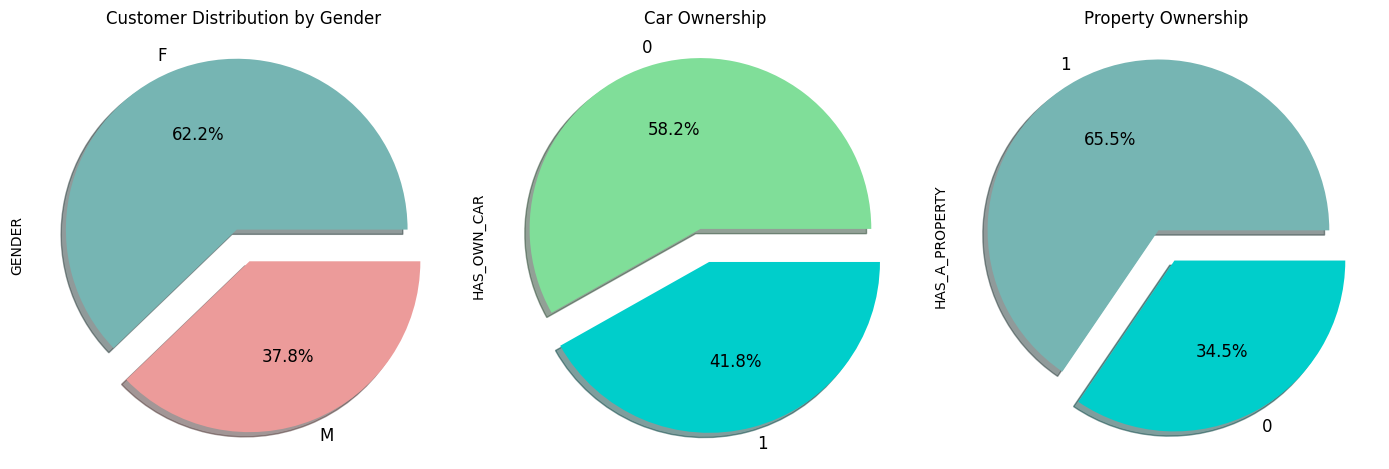

In [32]:
#Demographic (GENDER) and ASSET OWNERSHIP (CAR and PROPERTY)
fig, axes = plt.subplots(1,3)

g1= application_df['GENDER'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True, colors=["#76B5B3","#EC9B9A"],textprops = {'fontsize':12}, ax=axes[0])
g1.set_title("Customer Distribution by Gender")

g2= application_df['HAS_OWN_CAR'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=["#80DE99","#00CECB"],textprops = {'fontsize':12}, ax=axes[1])
g2.set_title("Car Ownership")

g3= application_df['HAS_A_PROPERTY'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=["#76B5B3","#00CECB"],textprops = {'fontsize':12}, ax=axes[2])
g3.set_title("Property Ownership")

fig.set_size_inches(14,5)

plt.tight_layout()

plt.show()

In [33]:
# Demographic (WAY OF LIVING)
application_df['WAY_OF_LIVING'].value_counts()

House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: WAY_OF_LIVING, dtype: int64

In [34]:
# Demographic (EDUCATION LEVEL)
application_df['EDUCATION_LEVEL'].value_counts()

Secondary / secondary special    16808
Higher education                  7132
Incomplete higher                  993
Lower secondary                    187
Academic degree                     14
Name: EDUCATION_LEVEL, dtype: int64

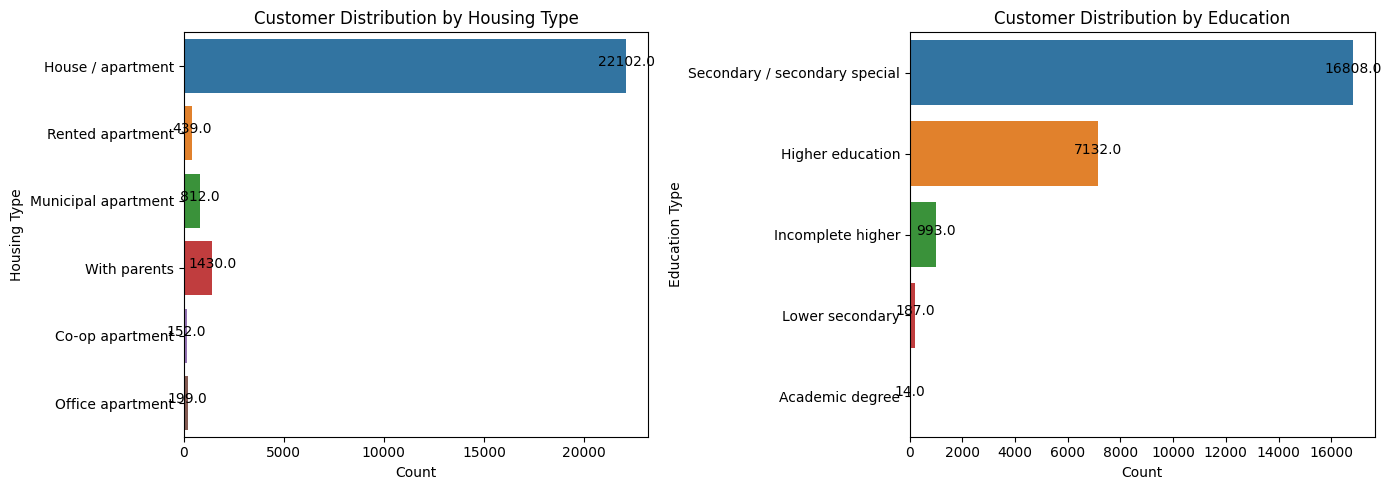

In [35]:
#Demographic (WAY_OF_LIVING) and (EDUCATION LEVEL)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

g1 = sns.countplot(y=application_df['WAY_OF_LIVING'], linewidth=1.2, ax=axes[0])
g1.set_title("Customer Distribution by Housing Type")
g1.set_xlabel("Count")
g1.set_ylabel("Housing Type")

# Annotate the count values on the bars in the first plot
for p in g1.patches:
    g1.annotate(f'{p.get_width()}', (p.get_width() + 5, p.get_y() + p.get_height() / 2), ha='center')

g2 = sns.countplot(y=application_df['EDUCATION_LEVEL'], ax=axes[1])
g2.set_title("Customer Distribution by Education")
g2.set_xlabel("Count")
g2.set_ylabel("Education Type")

# Annotate the count values on the bars in the second plot
for p in g2.patches:
    g2.annotate(f'{p.get_width()}', (p.get_width() + 5, p.get_y() + p.get_height() / 2), ha='center')

plt.tight_layout()
plt.show()


In [36]:
# Income (INCOME CATEGORY)
application_df['INCOME_CATEGORY'].value_counts()

Working                 15622
Commercial associate     7052
State servant            2437
Pensioner                  13
Student                    10
Name: INCOME_CATEGORY, dtype: int64

In [37]:
# Demographic (MARITAL STATUS)
application_df['MARITAL_STATUS'].value_counts()

Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: MARITAL_STATUS, dtype: int64

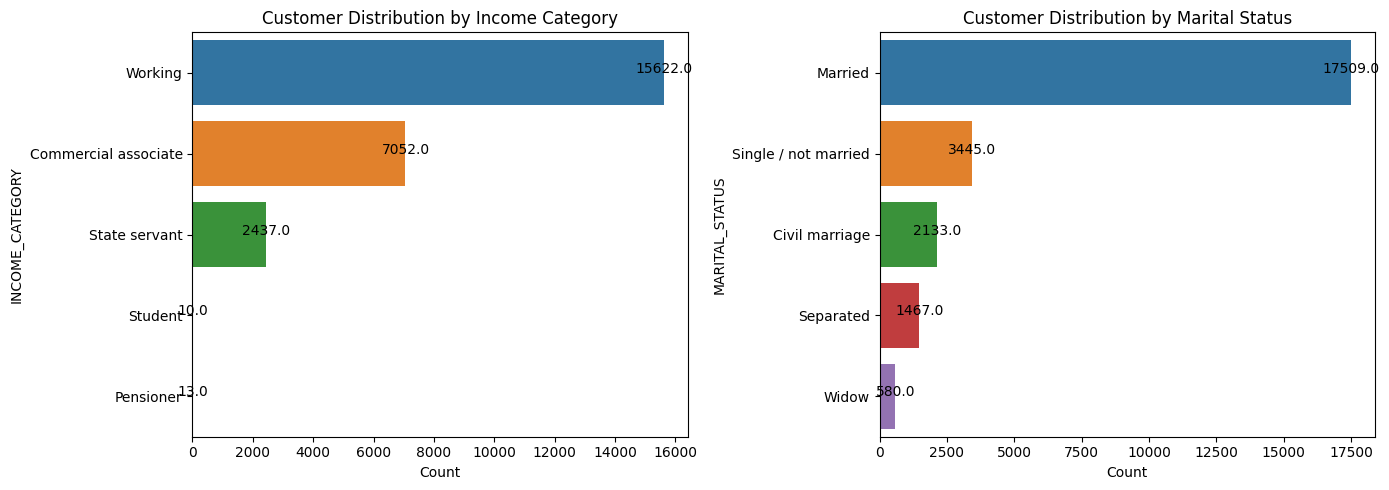

In [38]:
# Income (INCOME CATEGORY) and Demographic (MARITAL STATUS)
fig, axes = plt.subplots(1,2)

g1=sns.countplot(y=application_df.INCOME_CATEGORY,linewidth=1.2, ax=axes[0])
g1.set_title("Customer Distribution by Income Category")
g1.set_xlabel("Count")

# Annotate the count values on the bars in the first plot
for p in g1.patches:
    g1.annotate(f'{p.get_width()}', (p.get_width() + 5, p.get_y() + p.get_height() / 2), ha='center')

g2=sns.countplot(y=application_df.MARITAL_STATUS,linewidth=1.2, ax=axes[1])
g2.set_title("Customer Distribution by Marital Status")
g2.set_xlabel("Count")

# Annotate the count values on the bars in the first plot
for p in g2.patches:
    g2.annotate(f'{p.get_width()}', (p.get_width() + 5, p.get_y() + p.get_height() / 2), ha='center')

fig.set_size_inches(14,5)

plt.tight_layout()


plt.show()

In [39]:
# Demographic (COUNT CHILDREN)
application_df['CNT_CHILDREN'].value_counts()

0     15908
1      6118
2      2715
3       312
4        57
5        18
14        3
7         2
19        1
Name: CNT_CHILDREN, dtype: int64

In [40]:
# Demographic (AGE)
application_df['AGE'].value_counts()

39    952
41    929
28    919
37    911
40    879
30    876
35    870
42    870
34    870
38    862
44    855
33    844
29    832
32    795
43    765
36    764
47    747
31    740
45    740
49    691
51    677
48    673
27    664
52    651
46    610
50    583
55    512
54    509
53    507
26    414
25    371
57    297
56    273
58    269
24    240
60    235
61    204
23    167
59    164
63     95
62     75
22     71
64     67
65     58
67     18
66      9
21      7
68      2
20      1
Name: AGE, dtype: int64

In [41]:
# Demographic (EMPLOYMENT LENGTH)
application_df['EMPLOYMENT_LENGTH'].value_counts()

1     2630
3     2477
4     2341
2     2281
0     2066
5     1737
6     1665
8     1429
7     1422
9     1145
10     911
11     649
12     574
14     491
13     462
15     452
20     285
16     266
19     221
18     216
17     201
22     143
24     140
21     139
23     126
25      95
27      85
26      78
28      78
29      77
33      57
34      36
32      28
35      25
30      22
41      16
38      14
31      14
36      14
40      10
37       9
43       5
39       2
Name: EMPLOYMENT_LENGTH, dtype: int64

In [42]:
# Demographic (ANNUAL INCOME)
application_df['ANNUAL_INCOME'].value_counts()

135000    3012
180000    2312
157500    2205
225000    2169
112500    1943
          ... 
191700       1
134995       1
164250       1
124200       1
179271       1
Name: ANNUAL_INCOME, Length: 195, dtype: int64

In [43]:
sns.set_context("notebook",font_scale=.7,rc={"grid.linewidth": 0.1,'patch.linewidth': 0.0,
    "axes.grid":True,
    "grid.linestyle": "-",
    "axes.titlesize" : 13,
    "figure.autolayout":True})

palette_1 = ['#FF5E5B','#EC9B9A','#00CECB','#80DE99','#C0E680','#FFED66']

sns.set_palette(sns.color_palette(sns.color_palette(palette_1)))

<Figure size 1000x1000 with 0 Axes>

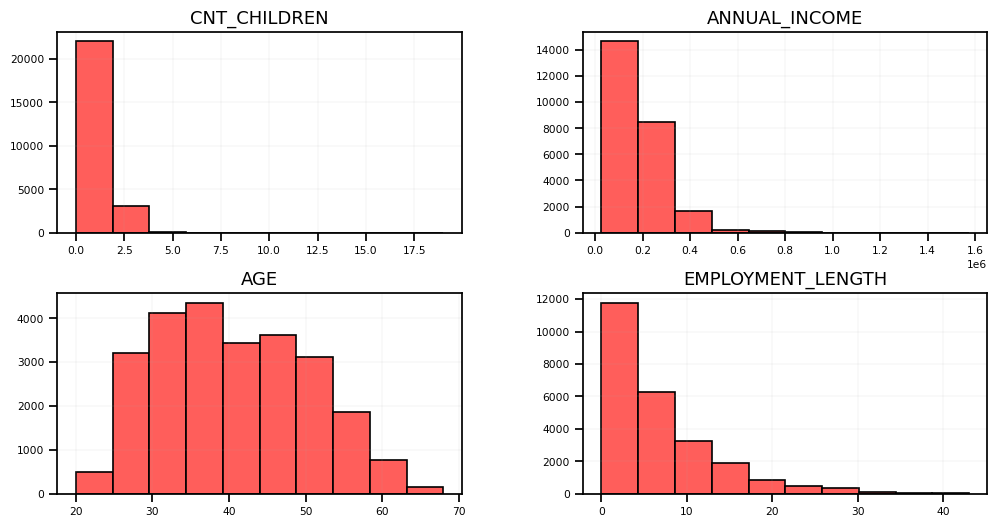

In [44]:
plt.figure(figsize=(10,10))

cols_to_plot = ["CNT_CHILDREN","ANNUAL_INCOME","AGE","EMPLOYMENT_LENGTH"]
application_df[cols_to_plot].hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,6)

## Credit Card Dataset

In [45]:
#Find for Elbow
from tqdm.auto import tqdm

score = []
for i in tqdm(range(2,9)):
  model = KMeans(n_clusters=i)
  model.fit(count_rec.drop(columns=['ID']))
  score.append(model.inertia_)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

In [46]:
px.line(x=np.arange(2,9),y=score,markers=True)

In [47]:
#Take 3 as the elbow for n_cluster param
model = KMeans(n_clusters=3)
cluster = model.fit_predict(count_rec.drop(columns=['ID','sum']))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [48]:
#Assign cluster to the credit activities Dataframe
count_rec['cluster'] = cluster
count_rec

STATUS,ID,0,1,2,3,4,5,C,X,sum,cluster
0,5008806,7,0,0,0,0,0,7,16,30,2
1,5008810,6,0,0,0,0,0,15,6,27,0
2,5008811,6,0,0,0,0,0,27,6,39,0
3,5008825,25,1,0,0,0,0,0,0,26,1
4,5008826,5,7,0,0,0,0,18,0,30,0
...,...,...,...,...,...,...,...,...,...,...,...
11655,5150476,17,0,0,0,0,0,0,5,22,1
11656,5150477,17,0,0,0,0,0,0,4,21,1
11657,5150480,6,0,0,0,0,0,20,0,26,0
11658,5150481,0,0,0,0,0,0,0,43,43,2


In [49]:
count_rec[count_rec.cluster==2]

STATUS,ID,0,1,2,3,4,5,C,X,sum,cluster
0,5008806,7,0,0,0,0,0,7,16,30,2
15,5008857,0,0,0,0,0,0,0,28,28,2
40,5008984,0,0,0,0,0,0,3,56,59,2
48,5009062,3,0,0,0,0,0,16,19,38,2
49,5009063,3,0,0,0,0,0,6,19,28,2
...,...,...,...,...,...,...,...,...,...,...,...
11647,5150403,0,0,0,0,0,0,0,39,39,2
11648,5150405,0,0,0,0,0,0,0,49,49,2
11649,5150408,6,0,0,0,0,0,0,27,33,2
11651,5150460,0,0,0,0,0,0,0,39,39,2


In [50]:
#Visualization to reducted variable into 3 respect to their cluster
pca = PCA(n_components=3).fit_transform(count_rec.drop(columns=['ID']))
px.scatter_3d(x=pca.T[0],y=pca.T[1],z=pca.T[2],color=cluster.astype(str))

In [51]:
#Create percentage columns Credit Score
count_rec['%0'] = count_rec['0']/count_rec['sum']*100
count_rec['%1'] = count_rec['1']/count_rec['sum']*100
count_rec['%2'] = count_rec['2']/count_rec['sum']*100
count_rec['%3'] = count_rec['3']/count_rec['sum']*100
count_rec['%4'] = count_rec['4']/count_rec['sum']*100
count_rec['%5'] = count_rec['5']/count_rec['sum']*100
count_rec['%C'] = count_rec['C']/count_rec['sum']*100
count_rec['%X'] = count_rec['X']/count_rec['sum']*100

In [52]:
#Visualization for each cluster properties
df1=count_rec.drop(columns=['ID','0','1','2','3','4','5','X','C','sum']).groupby("cluster").mean().reset_index() #taking mean percentage of each status in cluster
df2=count_rec[['cluster','sum']].groupby("cluster").median().reset_index() #taking median of the activities of each status in clusters
temp_polar = pd.merge(df2,df1,how='inner',on='cluster')

polar=pd.melt(temp_polar,id_vars=["cluster"])
fig = px.line_polar(polar, r="value", theta="STATUS", color="cluster", line_close=True,range_r= [-10,100], height=900,width=1000
                   ,template='ggplot2')
fig.show()

In [53]:
temp_polar

STATUS,cluster,sum,%0,%1,%2,%3,%4,%5,%C,%X
0,0,36.0,19.365685,0.752008,0.082550,0.022252,0.015850,0.064955,76.908304,2.788396
1,1,27.0,70.587852,2.019289,0.165544,0.062668,0.060560,0.423480,16.413572,10.267037
2,2,33.0,7.110946,0.240436,0.041281,0.014998,0.009267,0.187226,3.038325,89.357521


Result Clustering Credit Score:
* Cluster 0 : This cluster has the lowest activity level with a median of 27 activities. This cluster mostly experiences type 0 late payments (70%) but occasionally makes on-time payments (16%).
* Cluster 1 : With a median of 36 activities, this cluster generally pays on time (77%) but sometimes shows a pattern of late payments, especially type 0 delays, which occur in 19% of cases.
* Cluster 2 : This group has a median of 33 activities and tends to have no credit during their credit period, accounting for 89% of cases.

#5). Merge Dataset

In [54]:
without_sum_full_df = pd.merge(application_df,count_rec[['ID','cluster']],how='inner',on='ID')
without_sum_full_df

,ID,GENDER,HAS_OWN_CAR,HAS_A_PROPERTY,CNT_CHILDREN,ANNUAL_INCOME,INCOME_CATEGORY,EDUCATION_LEVEL,MARITAL_STATUS,WAY_OF_LIVING,AGE,EMPLOYMENT_LENGTH,JOB_TITTLE,FAMILY_MEMBER_COUNT,cluster
0,5008806,M,1,1,0,112500,Working,Secondary / secondary special,Married,House / apartment,59,3,Security staff,2,2
1,5008810,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1,0
2,5008811,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1,0
3,5112956,M,1,1,0,270000,Working,Higher education,Married,House / apartment,46,2,Accountants,2,1
4,5008825,F,1,0,0,130500,Working,Incomplete higher,Married,House / apartment,29,3,Accountants,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11655,5149145,M,1,1,0,247500,Working,Secondary / secondary special,Married,House / apartment,30,9,Laborers,2,0
11656,5149158,M,1,1,0,247500,Working,Secondary / secondary special,Married,House / apartment,30,9,Laborers,2,0
11657,5149775,F,1,1,0,130500,Working,Secondary / secondary special,Married,House / apartment,44,26,Laborers,2,0
11658,5149834,F,0,1,0,157500,Commercial associate,Higher education,Married,House / apartment,34,3,Medicine staff,2,1


In [55]:
without_sum_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11660 entries, 0 to 11659
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   11660 non-null  int64 
 1   GENDER               11660 non-null  object
 2   HAS_OWN_CAR          11660 non-null  int64 
 3   HAS_A_PROPERTY       11660 non-null  int64 
 4   CNT_CHILDREN         11660 non-null  int64 
 5   ANNUAL_INCOME        11660 non-null  int64 
 6   INCOME_CATEGORY      11660 non-null  object
 7   EDUCATION_LEVEL      11660 non-null  object
 8   MARITAL_STATUS       11660 non-null  object
 9   WAY_OF_LIVING        11660 non-null  object
 10  AGE                  11660 non-null  int64 
 11  EMPLOYMENT_LENGTH    11660 non-null  int64 
 12  JOB_TITTLE           11660 non-null  object
 13  FAMILY_MEMBER_COUNT  11660 non-null  int64 
 14  cluster              11660 non-null  int32 
dtypes: int32(1), int64(8), object(6)
memory usage: 1.4+ M

## EDA after combine dataset

In [56]:
# F = Female, M = Male
without_sum_full_df['GENDER'].value_counts()

F    7190
M    4470
Name: GENDER, dtype: int64

In [57]:
# 0 is don't have a CAR, and 1 is have a CAR
without_sum_full_df['HAS_OWN_CAR'].value_counts()

0    6525
1    5135
Name: HAS_OWN_CAR, dtype: int64

In [58]:
# 0 is don't have a PROPERTY, and 1 have a PROPERTY
without_sum_full_df['HAS_A_PROPERTY'].value_counts()

1    7433
0    4227
Name: HAS_A_PROPERTY, dtype: int64

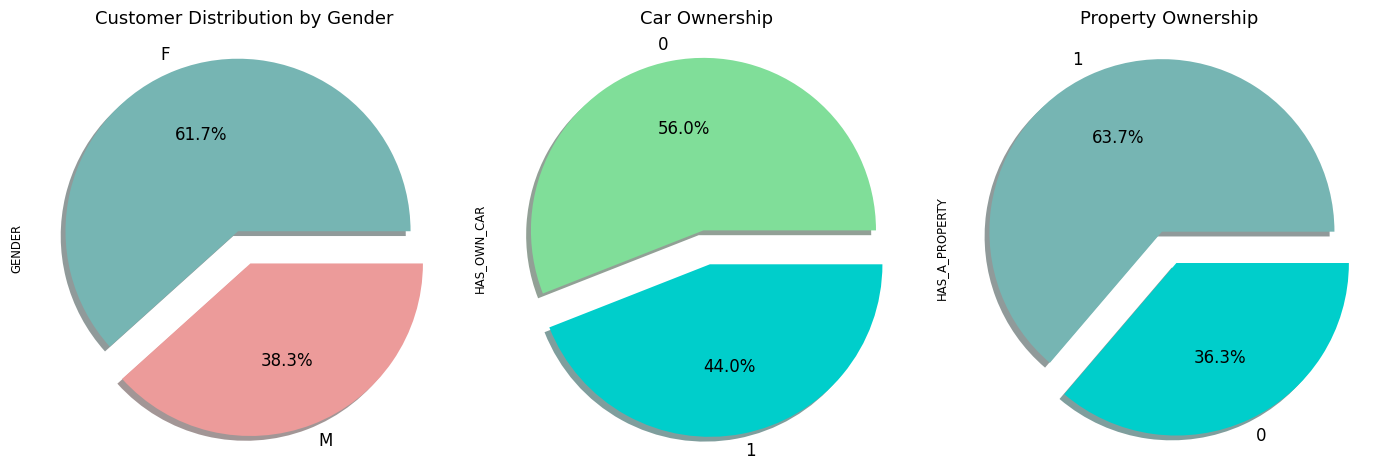

In [59]:
#Demographic (GENDER) and ASSET OWNERSHIP (CAR and PROPERTY)
fig, axes = plt.subplots(1,3)

g1= without_sum_full_df['GENDER'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True, colors=["#76B5B3","#EC9B9A"],textprops = {'fontsize':12}, ax=axes[0])
g1.set_title("Customer Distribution by Gender")

g2= without_sum_full_df['HAS_OWN_CAR'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=["#80DE99","#00CECB"],textprops = {'fontsize':12}, ax=axes[1])
g2.set_title("Car Ownership")

g3= without_sum_full_df['HAS_A_PROPERTY'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=["#76B5B3","#00CECB"],textprops = {'fontsize':12}, ax=axes[2])
g3.set_title("Property Ownership")

fig.set_size_inches(14,5)

plt.tight_layout()

plt.show()

In [60]:

# Assuming 'WAY_OF_LIVING' is the column of interest in the DataFrame
value_counts = without_sum_full_df['WAY_OF_LIVING'].value_counts()

# Calculate the percentages
percentages = (value_counts / len(without_sum_full_df)) * 100

# Create a DataFrame to display the results
result_df = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})

# Print or display the result DataFrame
print(result_df)


                     Count  Percentage
House / apartment    10295   88.293310
With parents           627    5.377358
Municipal apartment    387    3.319039
Rented apartment       181    1.552316
Office apartment        91    0.780446
Co-op apartment         79    0.677530


In [61]:
# Assuming 'EDUCATION_LEVEL' is the column of interest in the DataFrame
value_counts = without_sum_full_df['EDUCATION_LEVEL'].value_counts()

# Calculate the percentages
percentages = (value_counts / len(without_sum_full_df)) * 100

# Create a DataFrame to display the results
result_df = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})

# Print or display the result DataFrame
print(result_df)

                               Count  Percentage
Secondary / secondary special   7748   66.449400
Higher education                3365   28.859348
Incomplete higher                429    3.679245
Lower secondary                  105    0.900515
Academic degree                   13    0.111492


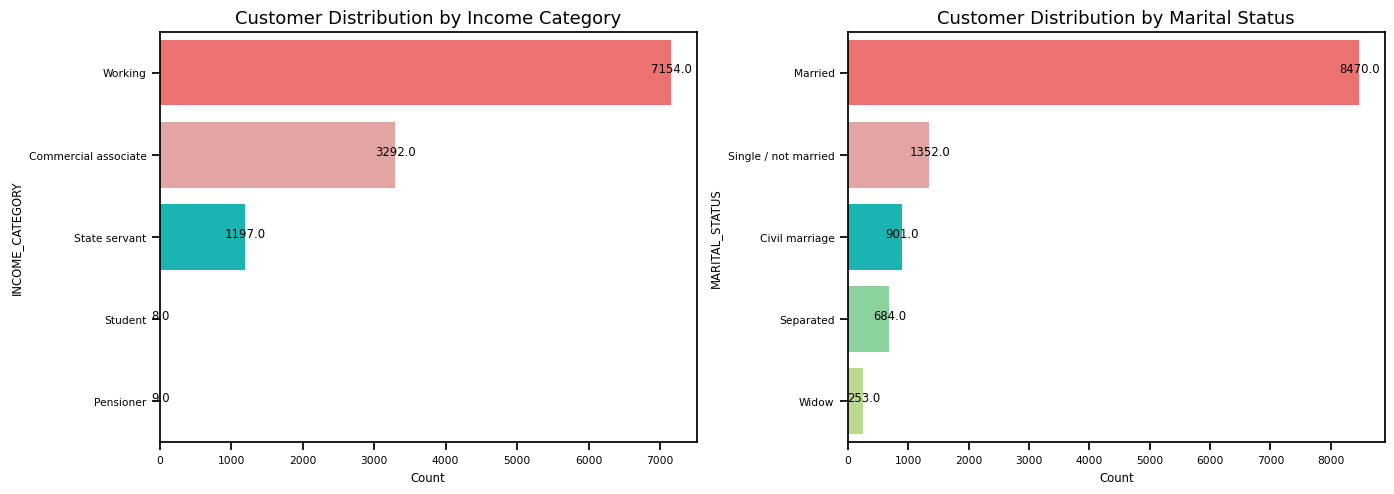

In [62]:
# Income (INCOME CATEGORY) and Demographic (MARITAL STATUS)
fig, axes = plt.subplots(1,2)

g1=sns.countplot(y=without_sum_full_df.INCOME_CATEGORY,linewidth=1.2, ax=axes[0])
g1.set_title("Customer Distribution by Income Category")
g1.set_xlabel("Count")

# Annotate the count values on the bars in the first plot
for p in g1.patches:
    g1.annotate(f'{p.get_width()}', (p.get_width() + 5, p.get_y() + p.get_height() / 2), ha='center')

g2=sns.countplot(y=without_sum_full_df.MARITAL_STATUS,linewidth=1.2, ax=axes[1])
g2.set_title("Customer Distribution by Marital Status")
g2.set_xlabel("Count")

# Annotate the count values on the bars in the first plot
for p in g2.patches:
    g2.annotate(f'{p.get_width()}', (p.get_width() + 5, p.get_y() + p.get_height() / 2), ha='center')

fig.set_size_inches(14,5)

plt.tight_layout()


plt.show()

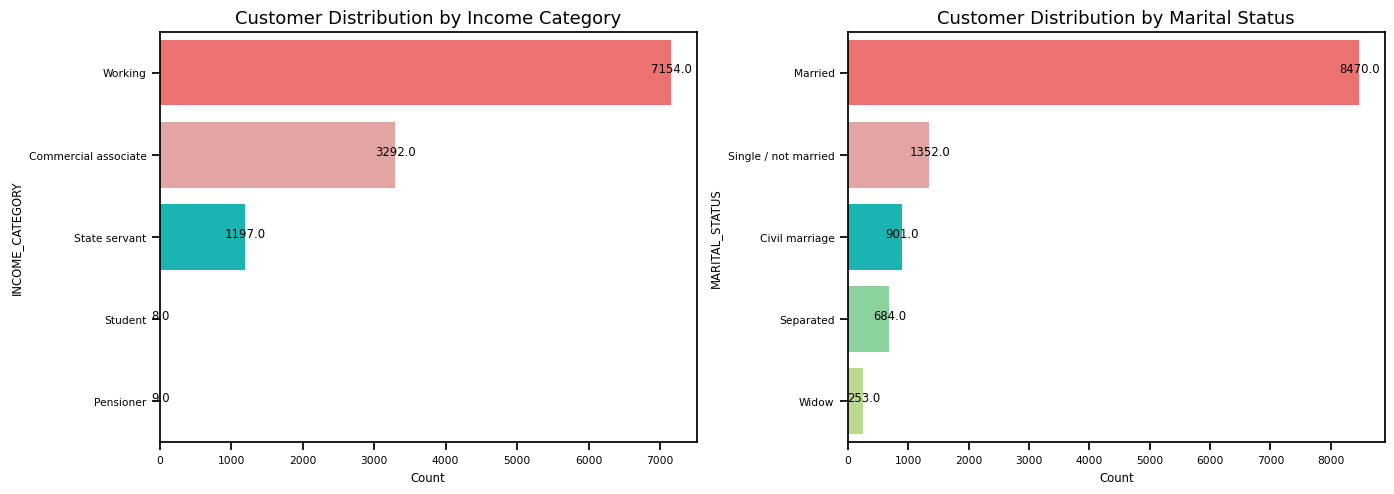

In [63]:
# Assuming 'INCOME_CATEGORY' and 'MARITAL_STATUS' are the column names in your DataFrame
fig, axes = plt.subplots(1, 2)

g1 = sns.countplot(y=without_sum_full_df.INCOME_CATEGORY, linewidth=1.2, ax=axes[0])
g1.set_title("Customer Distribution by Income Category")
g1.set_xlabel("Count")

# Annotate the count values on the bars in the first plot
for p in g1.patches:
    g1.annotate(f'{p.get_width()}', (p.get_width() + 5, p.get_y() + p.get_height() / 2), ha='center')

g2 = sns.countplot(y=without_sum_full_df.MARITAL_STATUS, linewidth=1.2, ax=axes[1])
g2.set_title("Customer Distribution by Marital Status")
g2.set_xlabel("Count")

# Annotate the count values on the bars in the second plot
for p in g2.patches:
    g2.annotate(f'{p.get_width()}', (p.get_width() + 5, p.get_y() + p.get_height() / 2), ha='center')

fig.set_size_inches(14, 5)

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('customer_distribution.png')

# Display the plot
plt.show()

In [64]:
sns.set_context("notebook",font_scale=.7,rc={"grid.linewidth": 0.1,'patch.linewidth': 0.0,
    "axes.grid":True,
    "grid.linestyle": "-",
    "axes.titlesize" : 13,
    "figure.autolayout":True})

palette_1 = ['#FF5E5B','#EC9B9A','#00CECB','#80DE99','#C0E680','#FFED66']

sns.set_palette(sns.color_palette(sns.color_palette(palette_1)))

<Figure size 1000x1000 with 0 Axes>

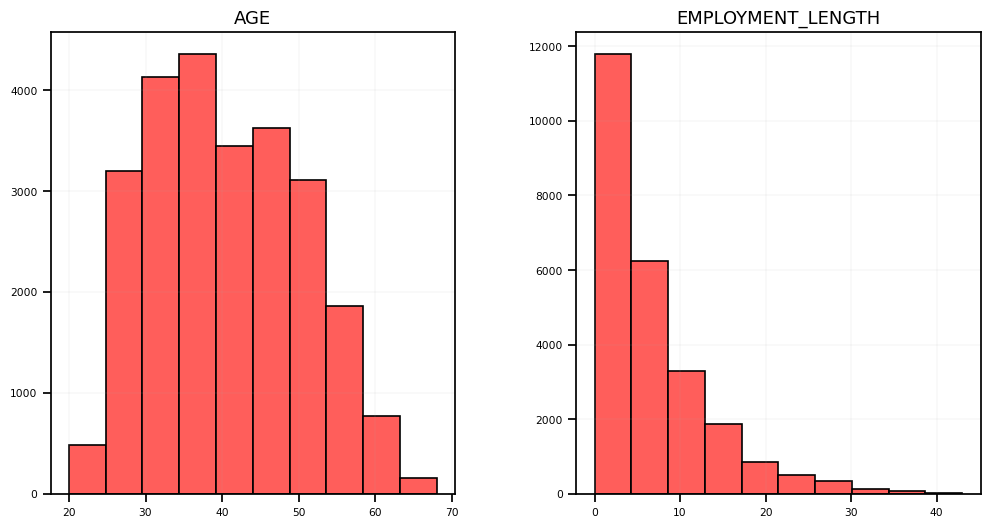

In [65]:
plt.figure(figsize=(10,10))

cols_to_plot = ["AGE","EMPLOYMENT_LENGTH"]
application_df[cols_to_plot].hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,6)

In [66]:
without_sum_full_df.cluster.value_counts()

0    6200
1    3632
2    1828
Name: cluster, dtype: int64

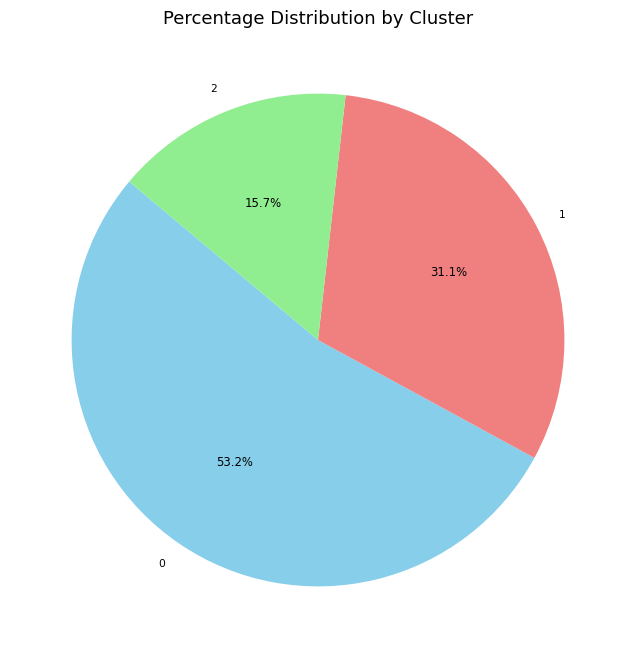

In [67]:
# Assuming 'cluster' is the column name in your DataFrame
cluster_counts = without_sum_full_df['cluster'].value_counts()
total_samples = len(without_sum_full_df)

# Calculate percentages
cluster_percentages = (cluster_counts / total_samples) * 100

# Define colors for the pie chart
colors = ['skyblue', 'lightcoral', 'lightgreen']

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(cluster_percentages, labels=cluster_percentages.index, autopct='%1.1f%%', startangle=140, colors=colors)

plt.title('Percentage Distribution by Cluster')

plt.show()

In [68]:
#Categorizing numerical value
num_merge = without_sum_full_df[['cluster','CNT_CHILDREN','ANNUAL_INCOME','AGE','EMPLOYMENT_LENGTH','FAMILY_MEMBER_COUNT']]

fig = make_subplots(rows=4, cols=2)
row = 1
check = 0
cols = 1
for col in (num_merge.columns[1:]):
  for cluster in num_merge.cluster.unique():
    trace = go.Box(y=num_merge[num_merge.cluster==cluster][col], name=col+':'+str(cluster))
    fig.append_trace(trace,row,cols)

  cols += 1
  if cols == 3:
    cols = 1

    row += 1
fig.update_layout(width=1000,height=2000, barmode='group')
fig.show()

BASED ON THE BOXPLOT

Income\ A: 27k - 135k\ B: 135k - 180k\ C: 180k - 247.5k\ D: 247.5k - 405k\ E: > 405k

Age\ A: 21 - 34\ B: 34 - 42\ C: 42 - 49\ D: 49 - 68

Employment\ A: 0 - 3\ B: 3 - 6\ C: 6 - 10\ D: 10 - 22\ E: > 22

Family\ A: 1\ B: 2\ C: 3\ D: > 4

Children\ A: 0\ B: 1\ C: 2\ D: > 2

In [69]:
#Creating categoric variable for numeric variable based on the boxplot
without_sum = without_sum_full_df.copy()

without_sum['ANNUAL_INCOME'] = np.where((without_sum.ANNUAL_INCOME>=27000)&(without_sum.ANNUAL_INCOME<=135000),'27k - 135k',
                            np.where((without_sum.ANNUAL_INCOME>135000)&(without_sum.ANNUAL_INCOME<=180000),'135k - 180k',
                            np.where((without_sum.ANNUAL_INCOME>180000)&(without_sum.ANNUAL_INCOME<=247500),'180k - 247.5k',
                            np.where((without_sum.ANNUAL_INCOME>247500)&(without_sum.ANNUAL_INCOME<=405000),'247.5k - 405k','>405k'))))
without_sum['AGE'] = np.where((without_sum.AGE>=21)&(without_sum.AGE<=34),'21 - 34 yrs',
                         np.where((without_sum.AGE>34)&(without_sum.AGE<=42),'34 - 42 yrs',
                         np.where((without_sum.AGE>42)&(without_sum.AGE<=49),'42 - 49 yrs','>49 yrs')))
without_sum['EMPLOYMENT_LENGTH'] = np.where((without_sum.EMPLOYMENT_LENGTH>=0)&(without_sum.EMPLOYMENT_LENGTH<=3),'0 - 3 yrs',
                                       np.where((without_sum.EMPLOYMENT_LENGTH>3)&(without_sum.EMPLOYMENT_LENGTH<=6),'3 - 6 yrs',
                                       np.where((without_sum.EMPLOYMENT_LENGTH>6)&(without_sum.EMPLOYMENT_LENGTH<=10),'6 - 10 yrs',
                                       np.where((without_sum.EMPLOYMENT_LENGTH>10)&(without_sum.EMPLOYMENT_LENGTH<=22),'10 - 22 yrs','>22 yrs'))))
without_sum['FAMILY_MEMBER_COUNT'] = np.where(without_sum.FAMILY_MEMBER_COUNT==1,'1',
                                         np.where(without_sum.FAMILY_MEMBER_COUNT==2,'2',
                                         np.where(without_sum.FAMILY_MEMBER_COUNT==3,'3','>3')))
without_sum['CNT_CHILDREN'] = np.where(without_sum.CNT_CHILDREN==0,'0',
                                    np.where(without_sum.CNT_CHILDREN==1,'1',
                                    np.where(without_sum.CNT_CHILDREN==2,'2','>2')))


## Counting Each Properties from Every Cluster

In [70]:
#Counting Each Properties from Every Cluster
dum_categoric_ws_unique = pd.get_dummies(without_sum.drop(columns=['JOB_TITTLE']), columns=['GENDER', 'HAS_OWN_CAR', 'HAS_A_PROPERTY', 'CNT_CHILDREN','ANNUAL_INCOME', 'INCOME_CATEGORY', 'EDUCATION_LEVEL','MARITAL_STATUS','WAY_OF_LIVING', 'AGE', 'EMPLOYMENT_LENGTH','FAMILY_MEMBER_COUNT'])

scale = MinMaxScaler()
dum_cat_group_ws_unique = dum_categoric_ws_unique.drop(columns=['ID']).groupby('cluster').sum().reset_index()
dum_categoric_ws_unique_scaled = scale.fit_transform(dum_cat_group_ws_unique.drop(columns=['cluster']))
dum_categoric_ws_unique_scaled = pd.DataFrame(columns = dum_cat_group_ws_unique.columns[1:], data=dum_categoric_ws_unique_scaled).reset_index().rename(columns={'index':'cluster'})
dum_categoric_ws_unique


,ID,cluster,GENDER_F,GENDER_M,HAS_OWN_CAR_0,HAS_OWN_CAR_1,HAS_A_PROPERTY_0,HAS_A_PROPERTY_1,CNT_CHILDREN_0,CNT_CHILDREN_1,...,AGE_>49 yrs,EMPLOYMENT_LENGTH_0 - 3 yrs,EMPLOYMENT_LENGTH_10 - 22 yrs,EMPLOYMENT_LENGTH_3 - 6 yrs,EMPLOYMENT_LENGTH_6 - 10 yrs,EMPLOYMENT_LENGTH_>22 yrs,FAMILY_MEMBER_COUNT_1,FAMILY_MEMBER_COUNT_2,FAMILY_MEMBER_COUNT_3,FAMILY_MEMBER_COUNT_>3
0,5008806,2,0,1,0,1,0,1,1,0,...,1,1,0,0,0,0,0,1,0,0
1,5008810,0,1,0,1,0,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
2,5008811,0,1,0,1,0,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
3,5112956,1,0,1,0,1,0,1,1,0,...,0,1,0,0,0,0,0,1,0,0
4,5008825,1,1,0,0,1,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11655,5149145,0,0,1,0,1,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
11656,5149158,0,0,1,0,1,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
11657,5149775,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,1,0,1,0,0
11658,5149834,1,1,0,1,0,0,1,1,0,...,0,1,0,0,0,0,0,1,0,0


In [71]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
x = dum_categoric_ws_unique.drop("cluster", axis=1)
y = dum_categoric_ws_unique["cluster"]

In [73]:
classifier = RandomForestClassifier()
classifier.fit(x, y)
classifier.score(x, y)

0.9996569468267581

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import  classification_report

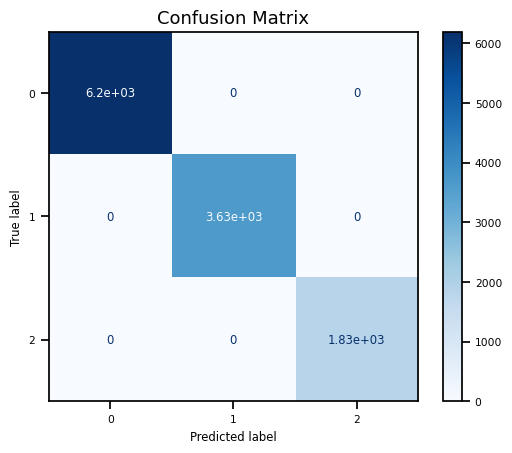

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have already trained your classifier and made predictions
classifier.fit(x, y)
y = classifier.predict(x)

# Create a confusion matrix
cm = confusion_matrix(y, y)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot(cmap=plt.cm.Blues, values_format=".3g")

plt.title("Confusion Matrix")
plt.show()


In [76]:
dum_categoric_ws_unique.columns

Index(['ID', 'cluster', 'GENDER_F', 'GENDER_M', 'HAS_OWN_CAR_0',
       'HAS_OWN_CAR_1', 'HAS_A_PROPERTY_0', 'HAS_A_PROPERTY_1',
       'CNT_CHILDREN_0', 'CNT_CHILDREN_1', 'CNT_CHILDREN_2', 'CNT_CHILDREN_>2',
       'ANNUAL_INCOME_135k - 180k', 'ANNUAL_INCOME_180k - 247.5k',
       'ANNUAL_INCOME_247.5k - 405k', 'ANNUAL_INCOME_27k - 135k',
       'ANNUAL_INCOME_>405k', 'INCOME_CATEGORY_Commercial associate',
       'INCOME_CATEGORY_Pensioner', 'INCOME_CATEGORY_State servant',
       'INCOME_CATEGORY_Student', 'INCOME_CATEGORY_Working',
       'EDUCATION_LEVEL_Academic degree', 'EDUCATION_LEVEL_Higher education',
       'EDUCATION_LEVEL_Incomplete higher', 'EDUCATION_LEVEL_Lower secondary',
       'EDUCATION_LEVEL_Secondary / secondary special',
       'MARITAL_STATUS_Civil marriage', 'MARITAL_STATUS_Married',
       'MARITAL_STATUS_Separated', 'MARITAL_STATUS_Single / not married',
       'MARITAL_STATUS_Widow', 'WAY_OF_LIVING_Co-op apartment',
       'WAY_OF_LIVING_House / apartment',

In [77]:
Y = dum_categoric_ws_unique['cluster']
X = dum_categoric_ws_unique[['GENDER_F', 'GENDER_M', 'HAS_OWN_CAR_0',
       'HAS_OWN_CAR_1', 'HAS_A_PROPERTY_0', 'HAS_A_PROPERTY_1',
       'CNT_CHILDREN_0', 'CNT_CHILDREN_1', 'CNT_CHILDREN_2', 'CNT_CHILDREN_>2',
       'ANNUAL_INCOME_135k - 180k', 'ANNUAL_INCOME_180k - 247.5k',
       'ANNUAL_INCOME_247.5k - 405k', 'ANNUAL_INCOME_27k - 135k',
       'ANNUAL_INCOME_>405k', 'INCOME_CATEGORY_Commercial associate',
       'INCOME_CATEGORY_Pensioner', 'INCOME_CATEGORY_State servant',
       'INCOME_CATEGORY_Student', 'INCOME_CATEGORY_Working',
       'EDUCATION_LEVEL_Academic degree', 'EDUCATION_LEVEL_Higher education',
       'EDUCATION_LEVEL_Incomplete higher', 'EDUCATION_LEVEL_Lower secondary',
       'EDUCATION_LEVEL_Secondary / secondary special',
       'MARITAL_STATUS_Civil marriage', 'MARITAL_STATUS_Married',
       'MARITAL_STATUS_Separated', 'MARITAL_STATUS_Single / not married',
       'MARITAL_STATUS_Widow', 'WAY_OF_LIVING_Co-op apartment',
       'WAY_OF_LIVING_House / apartment', 'WAY_OF_LIVING_Municipal apartment',
       'WAY_OF_LIVING_Office apartment', 'WAY_OF_LIVING_Rented apartment',
       'WAY_OF_LIVING_With parents', 'AGE_21 - 34 yrs', 'AGE_34 - 42 yrs',
       'AGE_42 - 49 yrs', 'AGE_>49 yrs', 'EMPLOYMENT_LENGTH_0 - 3 yrs',
       'EMPLOYMENT_LENGTH_10 - 22 yrs', 'EMPLOYMENT_LENGTH_3 - 6 yrs',
       'EMPLOYMENT_LENGTH_6 - 10 yrs', 'EMPLOYMENT_LENGTH_>22 yrs',
       'FAMILY_MEMBER_COUNT_1', 'FAMILY_MEMBER_COUNT_2',
       'FAMILY_MEMBER_COUNT_3', 'FAMILY_MEMBER_COUNT_>3']]

In [78]:
from imblearn.over_sampling import SMOTE
Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

In [79]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((9328, 49), (2332, 49), (9328,), (2332,))

In [80]:
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV()
lr.fit(train_X, train_Y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

LogisticRegressionCV()

In [81]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(test_Y, lr.predict(test_X))
print()
print(classification_report(test_Y, lr.predict(test_X)))


              precision    recall  f1-score   support

           0       0.52      1.00      0.69      1221
           1       0.00      0.00      0.00       746
           2       0.00      0.00      0.00       365

    accuracy                           0.52      2332
   macro avg       0.17      0.33      0.23      2332
weighted avg       0.27      0.52      0.36      2332



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [82]:
lr.coef_

array([[ 3.02890390e-03, -3.03888572e-03,  4.72646411e-03,
        -4.73644594e-03, -2.60514627e-03,  2.59516444e-03,
        -1.51273722e-03,  7.15398787e-05,  1.71994591e-03,
        -2.88730397e-04,  7.15381808e-04, -1.89756933e-03,
        -7.14718906e-03,  9.35117899e-03, -1.03178424e-03,
        -2.47088903e-03,  2.20443388e-04, -8.46936949e-04,
         2.69645572e-04,  2.81775520e-03,  1.69027484e-04,
         1.45899638e-03,  6.35264140e-04,  5.85473293e-04,
        -2.85874312e-03,  2.67308932e-03, -3.90696913e-03,
        -3.28326680e-04,  1.95624730e-03, -4.04022624e-04,
        -4.17182150e-04,  9.34106526e-04, -3.96552539e-04,
        -8.76358183e-04, -1.06630970e-03,  1.81231423e-03,
         5.24546900e-03, -3.27303156e-03, -1.43272466e-03,
        -5.49694599e-04, -1.32649114e-03, -3.50710449e-03,
         2.10777048e-03,  3.08991233e-03, -3.74069007e-04,
        -5.61601778e-06,  8.86878450e-05, -1.92533650e-03,
         1.83228285e-03],
       [-9.79950263e-04,  9.66

In [83]:
X_train = X.sample(frac=0.9, random_state=123)
X_test = X.drop(X_train.index)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(X_train.shape))
print('Unseen Data For Predictions: ' + str(X_test.shape))

Data for Modeling: (10494, 49)
Unseen Data For Predictions: (1166, 49)


In [84]:
#Take the proportion of each variable from each cluster
data = [dum_cat_group_ws_unique.iloc[0,1:]/len(dum_categoric_ws_unique[dum_categoric_ws_unique.cluster==0])*100,
        dum_cat_group_ws_unique.iloc[1,1:]/len(dum_categoric_ws_unique[dum_categoric_ws_unique.cluster==1])*100,
        dum_cat_group_ws_unique.iloc[2,1:]/len(dum_categoric_ws_unique[dum_categoric_ws_unique.cluster==2])*100]
dum_cat_group_ws_unique_percentage = pd.DataFrame(data).reset_index().rename(columns={'index':'cluster'})

display(dum_cat_group_ws_unique)
display(dum_categoric_ws_unique_scaled)
display(dum_cat_group_ws_unique_percentage)

,cluster,GENDER_F,GENDER_M,HAS_OWN_CAR_0,HAS_OWN_CAR_1,HAS_A_PROPERTY_0,HAS_A_PROPERTY_1,CNT_CHILDREN_0,CNT_CHILDREN_1,CNT_CHILDREN_2,...,AGE_>49 yrs,EMPLOYMENT_LENGTH_0 - 3 yrs,EMPLOYMENT_LENGTH_10 - 22 yrs,EMPLOYMENT_LENGTH_3 - 6 yrs,EMPLOYMENT_LENGTH_6 - 10 yrs,EMPLOYMENT_LENGTH_>22 yrs,FAMILY_MEMBER_COUNT_1,FAMILY_MEMBER_COUNT_2,FAMILY_MEMBER_COUNT_3,FAMILY_MEMBER_COUNT_>3
0,0,3876,2324,3535,2665,2209,3991,3934,1459,722,...,1343,2031,1088,1465,1365,251,939,3248,1240,773
1,1,2230,1402,2022,1610,1326,2306,2344,839,386,...,845,1249,696,819,714,154,590,1889,720,433
2,2,1084,744,968,860,692,1136,1128,465,204,...,366,595,337,401,424,71,240,948,423,217


,cluster,GENDER_F,GENDER_M,HAS_OWN_CAR_0,HAS_OWN_CAR_1,HAS_A_PROPERTY_0,HAS_A_PROPERTY_1,CNT_CHILDREN_0,CNT_CHILDREN_1,CNT_CHILDREN_2,...,AGE_>49 yrs,EMPLOYMENT_LENGTH_0 - 3 yrs,EMPLOYMENT_LENGTH_10 - 22 yrs,EMPLOYMENT_LENGTH_3 - 6 yrs,EMPLOYMENT_LENGTH_6 - 10 yrs,EMPLOYMENT_LENGTH_>22 yrs,FAMILY_MEMBER_COUNT_1,FAMILY_MEMBER_COUNT_2,FAMILY_MEMBER_COUNT_3,FAMILY_MEMBER_COUNT_>3
0,0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
1,1,0.410458,0.416456,0.410596,0.415512,0.41793,0.409807,0.433357,0.376258,0.351351,...,0.490276,0.455432,0.478029,0.392857,0.308183,0.461111,0.500715,0.40913,0.363525,0.388489
2,2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


,cluster,GENDER_F,GENDER_M,HAS_OWN_CAR_0,HAS_OWN_CAR_1,HAS_A_PROPERTY_0,HAS_A_PROPERTY_1,CNT_CHILDREN_0,CNT_CHILDREN_1,CNT_CHILDREN_2,...,AGE_>49 yrs,EMPLOYMENT_LENGTH_0 - 3 yrs,EMPLOYMENT_LENGTH_10 - 22 yrs,EMPLOYMENT_LENGTH_3 - 6 yrs,EMPLOYMENT_LENGTH_6 - 10 yrs,EMPLOYMENT_LENGTH_>22 yrs,FAMILY_MEMBER_COUNT_1,FAMILY_MEMBER_COUNT_2,FAMILY_MEMBER_COUNT_3,FAMILY_MEMBER_COUNT_>3
0,0,62.516129,37.483871,57.016129,42.983871,35.629032,64.370968,63.451613,23.532258,11.645161,...,21.661290,32.758065,17.548387,23.629032,22.016129,4.048387,15.145161,52.387097,20.000000,12.467742
1,1,61.398678,38.601322,55.671806,44.328194,36.508811,63.491189,64.537445,23.100220,10.627753,...,23.265419,34.388767,19.162996,22.549559,19.658590,4.240088,16.244493,52.009912,19.823789,11.921806
2,2,59.299781,40.700219,52.954048,47.045952,37.855580,62.144420,61.706783,25.437637,11.159737,...,20.021882,32.549234,18.435449,21.936543,23.194748,3.884026,13.129103,51.859956,23.140044,11.870897


Create Polar

In [85]:
polar=pd.melt(dum_cat_group_ws_unique,id_vars=["cluster"])
fig1 = px.line_polar(polar, r="value", theta="variable", color="cluster", line_close=True,range_r= [-1000,5000], height=900,width=900
                   ,template='ggplot2')
fig1.show()

In [86]:
polar=pd.melt(dum_cat_group_ws_unique_percentage,id_vars=["cluster"])
fig1 = px.line_polar(polar, r="value", theta="variable", color="cluster", line_close=True,range_r= [-10,95], height=900,width=900
                   ,template='ggplot2')
fig1.show()

Because the properties are evenly distributed, it is challenging to determine which properties are most likely to be associated with a particular cluster. Therefore, we will analyze using K-Means Clustering all variables

#6). Data Modeling

## K-Means Clustering: Data Preparation

K-Means clustering can only works with numerical data, so let's create a copy of numerical-only data from df

In [87]:
df_cluster = without_sum_full_df.select_dtypes(include='number').copy()
df_cluster

,ID,HAS_OWN_CAR,HAS_A_PROPERTY,CNT_CHILDREN,ANNUAL_INCOME,AGE,EMPLOYMENT_LENGTH,FAMILY_MEMBER_COUNT,cluster
0,5008806,1,1,0,112500,59,3,2,2
1,5008810,0,1,0,270000,53,8,1,0
2,5008811,0,1,0,270000,53,8,1,0
3,5112956,1,1,0,270000,46,2,2,1
4,5008825,1,0,0,130500,29,3,2,1
...,...,...,...,...,...,...,...,...,...
11655,5149145,1,1,0,247500,30,9,2,0
11656,5149158,1,1,0,247500,30,9,2,0
11657,5149775,1,1,0,130500,44,26,2,0
11658,5149834,0,1,0,157500,34,3,2,1


In [88]:
df_cluster.describe()

,ID,HAS_OWN_CAR,HAS_A_PROPERTY,CNT_CHILDREN,ANNUAL_INCOME,AGE,EMPLOYMENT_LENGTH,FAMILY_MEMBER_COUNT,cluster
count,1.166000e+04,11660.000000,11660.000000,11660.000000,1.166000e+04,11660.000000,11660.000000,11660.000000,11660.000000
mean,5.079825e+06,0.440395,0.637479,0.513722,1.983809e+05,41.305060,7.299743,2.317410,0.625043
std,4.220565e+04,0.496456,0.480749,0.789154,1.045683e+05,9.337915,6.699161,0.935902,0.740244
min,5.008806e+06,0.000000,0.000000,0.000000,2.700000e+04,21.000000,0.000000,1.000000,0.000000
25%,5.045255e+06,0.000000,0.000000,0.000000,1.350000e+05,34.000000,3.000000,2.000000,0.000000
50%,5.085735e+06,0.000000,1.000000,0.000000,1.800000e+05,41.000000,6.000000,2.000000,0.000000
75%,5.116055e+06,1.000000,1.000000,1.000000,2.340000e+05,48.000000,10.000000,3.000000,1.000000
max,5.150487e+06,1.000000,1.000000,14.000000,1.575000e+06,68.000000,43.000000,15.000000,2.000000


## K-Means Clustering
For k-means clustering, we need to determine `n_clusters`, number of cluster we want to create.

Let's suppose we want to create 3 cluster of customer. Then n_clusters = 3

In [89]:
# Initialize KMeans for 3 clusters
cluster_model = KMeans(n_clusters = 3, random_state = 1000, n_init='auto')
cluster_model

KMeans(n_clusters=3, n_init='auto', random_state=1000)

In [90]:
# Fit the data into model
# Setelah declare modelnya, pertemukan dengan datanya
cluster_model.fit(df_cluster)

KMeans(n_clusters=3, n_init='auto', random_state=1000)

In [91]:
# Check up cluster label created by the KMeans
cluster_model.labels_

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [92]:
df_kmeans = df_cluster.copy()
df_kmeans['cluster'] = cluster_model.labels_
df_kmeans

,ID,HAS_OWN_CAR,HAS_A_PROPERTY,CNT_CHILDREN,ANNUAL_INCOME,AGE,EMPLOYMENT_LENGTH,FAMILY_MEMBER_COUNT,cluster
0,5008806,1,1,0,112500,59,3,2,1
1,5008810,0,1,0,270000,53,8,1,0
2,5008811,0,1,0,270000,53,8,1,0
3,5112956,1,1,0,270000,46,2,2,0
4,5008825,1,0,0,130500,29,3,2,1
...,...,...,...,...,...,...,...,...,...
11655,5149145,1,1,0,247500,30,9,2,0
11656,5149158,1,1,0,247500,30,9,2,0
11657,5149775,1,1,0,130500,44,26,2,1
11658,5149834,0,1,0,157500,34,3,2,1


In [93]:
df_kmeans.cluster.value_counts()

1    6699
0    4056
2     905
Name: cluster, dtype: int64

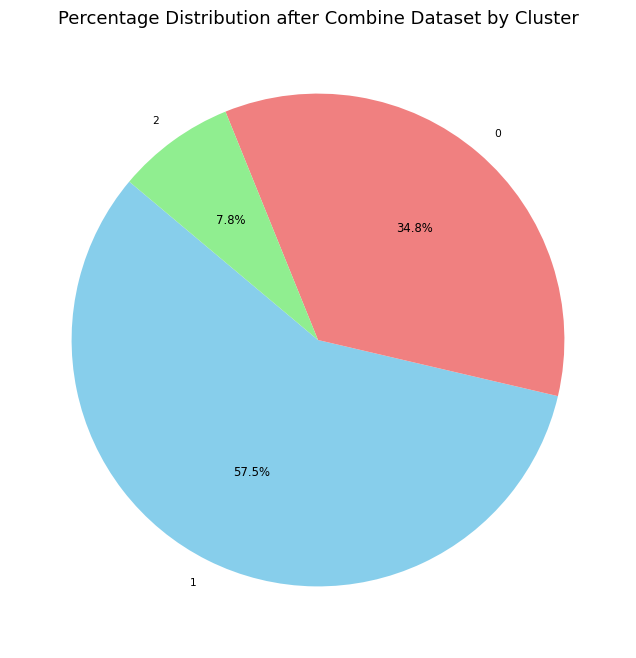

In [94]:
# Assuming 'cluster' is the column name in your DataFrame
cluster_counts =df_kmeans['cluster'].value_counts()
total_samples = len(df_kmeans)

# Calculate percentages
cluster_percentages = (cluster_counts / total_samples) * 100

# Define colors for the pie chart
colors = ['skyblue', 'lightcoral', 'lightgreen']

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(cluster_percentages, labels=cluster_percentages.index, autopct='%1.1f%%', startangle=140, colors=colors)

plt.title('Percentage Distribution after Combine Dataset by Cluster')

plt.show()

## Elbow Method
- Depends on distortion value (distortion is measure of how far each points to the center of cluster; the smallest the better)
- But usually we don't want to have too big number of cluster (not very actionable)
- Therefore we aim to choose the "elbow" -- number of cluster with low enough distortion value, but small count of cluster

In [95]:
# For each n_clusters between 1 and 11, we calculate the distortion value
distortions = []
K = range(1,11)
for n_clusters in K:
  kmeanModel = KMeans(n_clusters, random_state = 1000, n_init='auto')
  kmeanModel.fit(df_cluster)
  distortions.append(kmeanModel.inertia_)

distortions


[148254100107896.56,
 77141868783714.31,
 54125850601831.67,
 42301956395566.875,
 37549362256538.97,
 28277966495733.65,
 22955482400852.574,
 18786766342587.14,
 16866100466598.672,
 15222439107947.602]

<Figure size 1600x800 with 0 Axes>

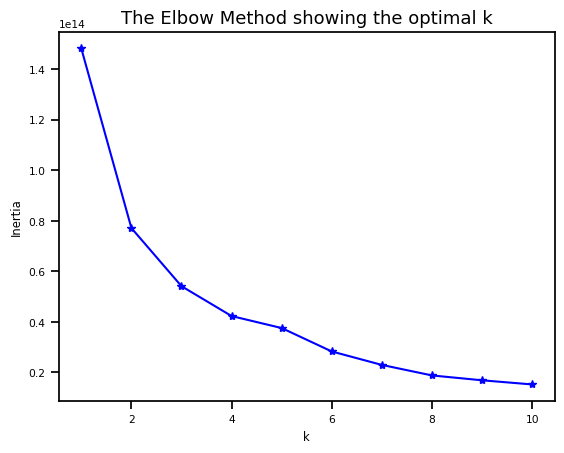

In [96]:
plt.figure(figsize=(16,8))
plt.figure()
plt.plot(K, distortions, 'b*-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

There are many potential elbows here: maybe k=2, k=3,  k=4, k=6

To be more certain, we need also to look into the silhouette plot.

## Silhouette Method
- Depends on silhouette score, ranged between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering.
- This is particularly useful for determining cluster imbalance, or for selecting a value for  by comparing multiple visualizers.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



0.41008282880349256

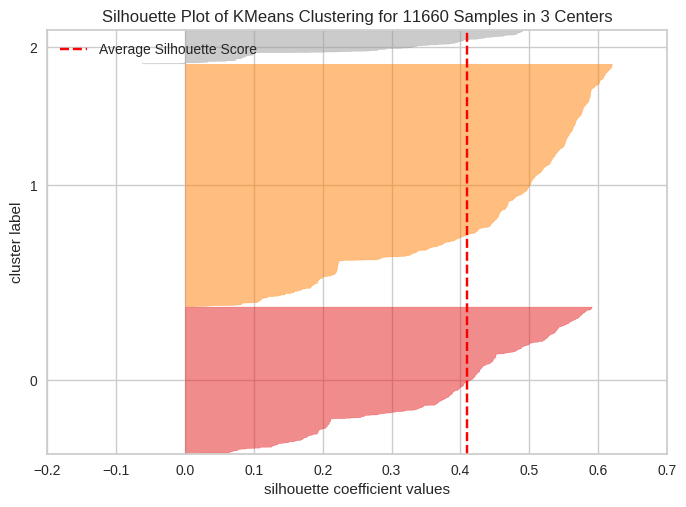

In [97]:
# Untuk k=3 clusters
from yellowbrick.cluster import SilhouetteVisualizer # Untuk melakukan analisis siluet untuk k-means clustering
cluster_model = KMeans(n_clusters = 3, random_state = 1000, n_init='auto')
cluster_model.fit(df_cluster)

sil = SilhouetteVisualizer(cluster_model, is_fitted = True)
sil.fit(df_cluster)
sil.finalize()
sil.silhouette_score_

For k=2, the average silhouette score is 0.5118255680483746
For k=3, the average silhouette score is 0.41008282880349256
For k=4, the average silhouette score is 0.3440434685850723
For k=5, the average silhouette score is 0.3767573042282643
For k=6, the average silhouette score is 0.380853569220575
For k=7, the average silhouette score is 0.3702592535056931
For k=8, the average silhouette score is 0.382676971391699
For k=9, the average silhouette score is 0.3900925326784539
For k=10, the average silhouette score is 0.36921413386765195


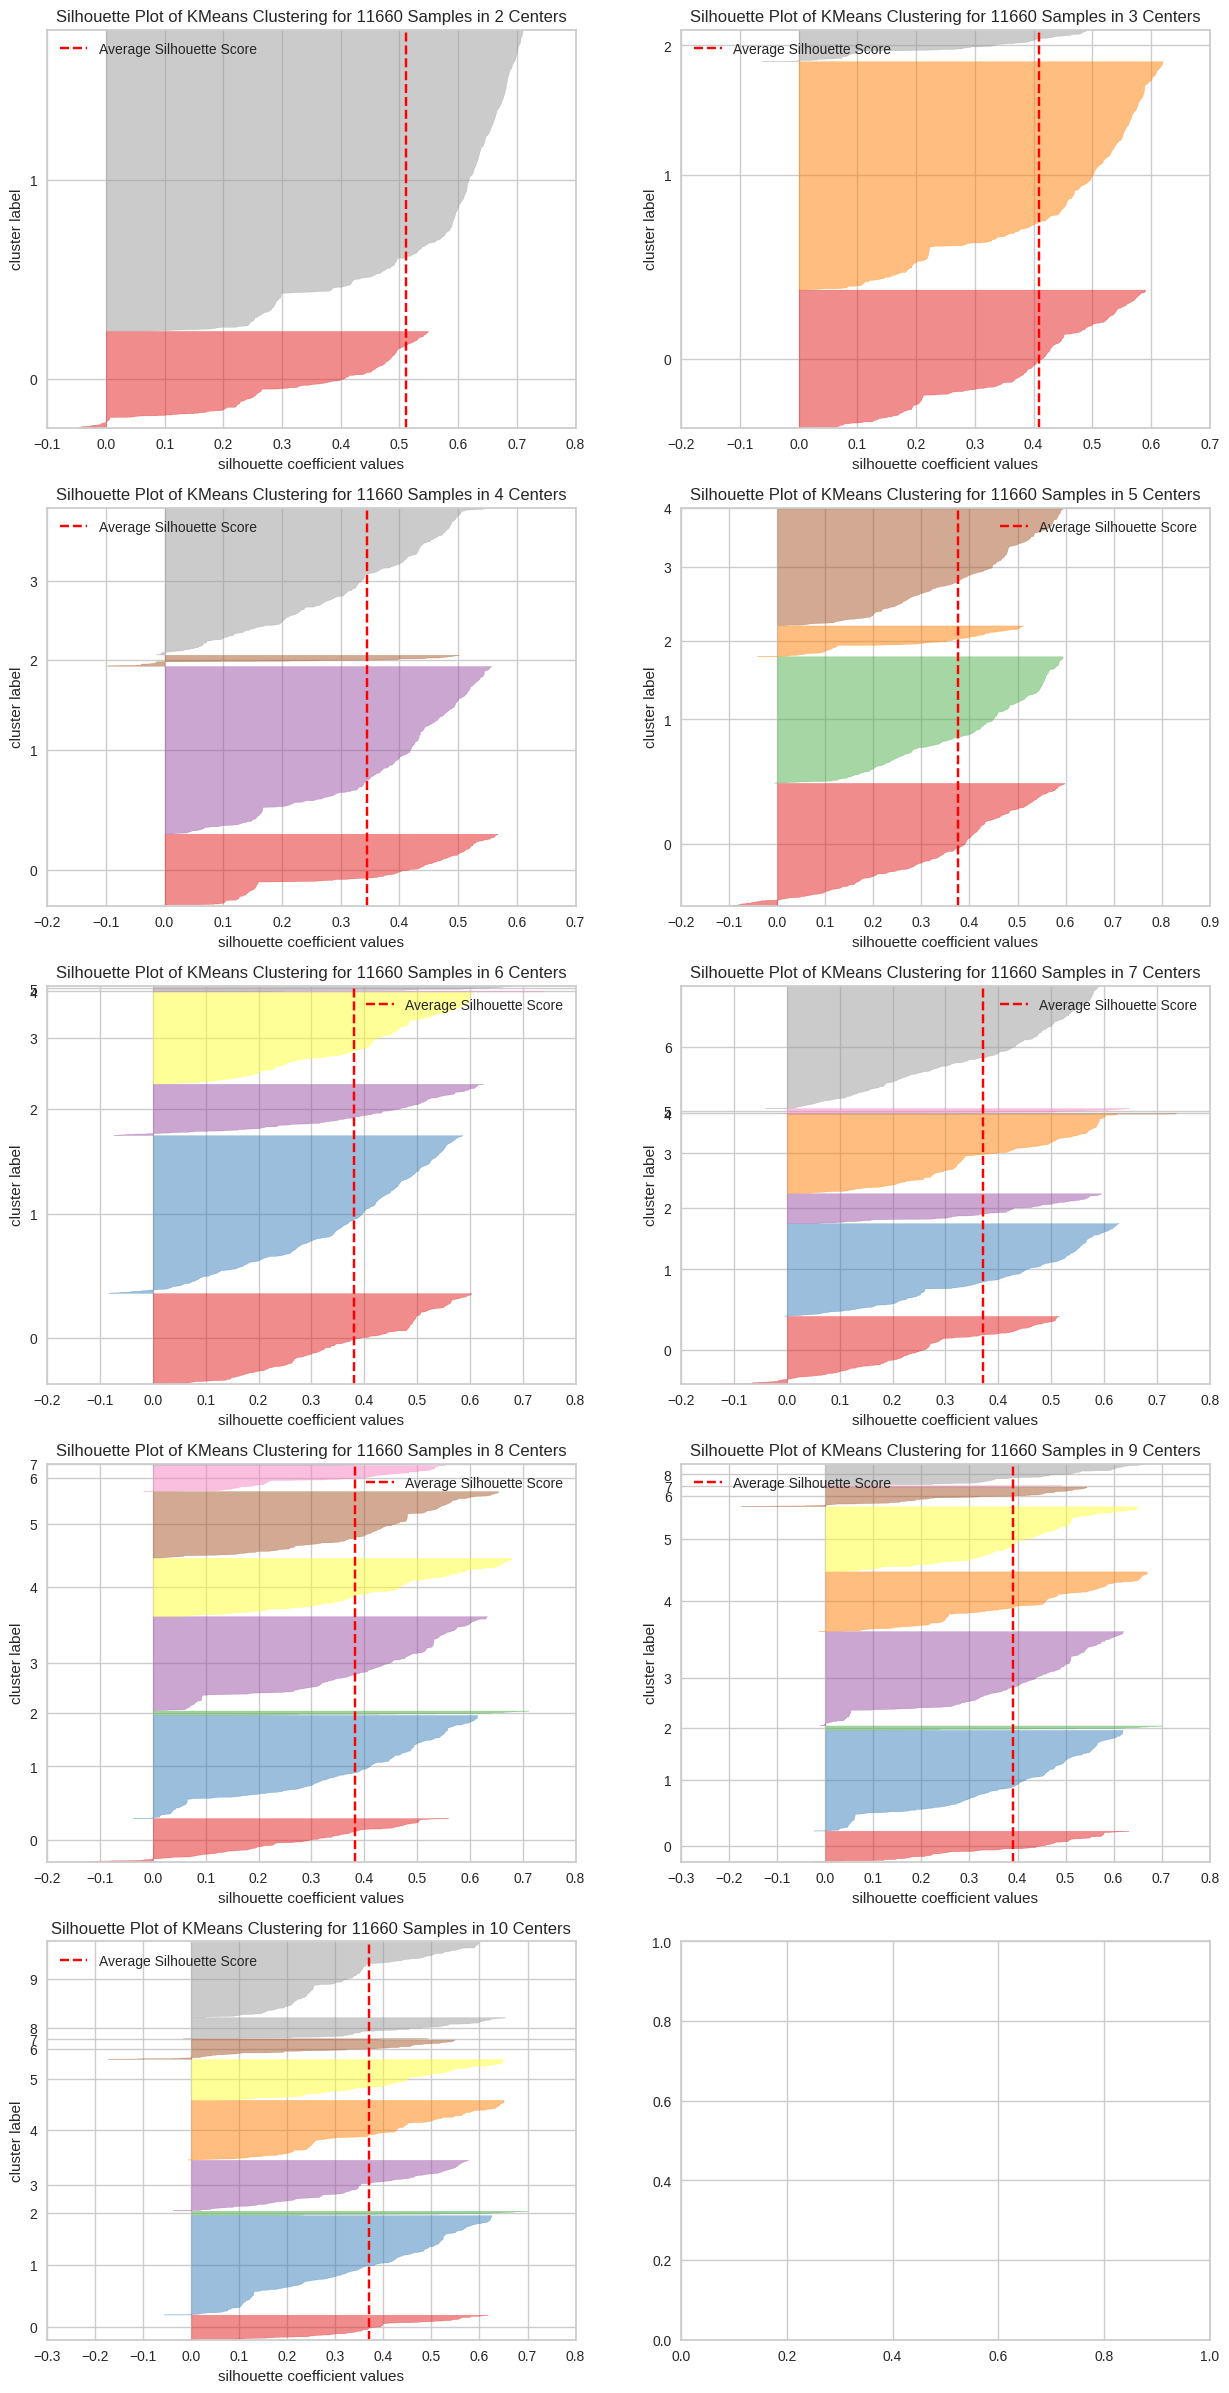

In [98]:
# Silhouette score plot
# Menurut siluet skor, harusnya kita pilih k=2
# Dan diagram siluetnya oke (tidak ada silhouette negative coefficient values)
K = range(2,11)
max_K = max(K)
fig, ax = plt.subplots(int(np.ceil(max_K/2)), 2, figsize = (15,30))

for n_clusters in K:
  kmeanModel = KMeans(n_clusters, random_state = 1000, n_init='auto')

  q, mod = divmod(n_clusters,2)
  sil = SilhouetteVisualizer(kmeanModel, is_fitted = False, ax = ax[q-1][mod])
  sil.fit(df_cluster)
  sil.finalize()
  print(f"For k={n_clusters}, the average silhouette score is {sil.silhouette_score_}")

Looks like:
- By elbow method, k=2, k=3, k=5, or k=6
- By highest siluet score, k=3
- k=3 siluet diagram looks OK (no negative coefficient values)
- But k=2 cannot be interpreted business-wise (karena kebanyakan (>80%) cust jatoh ke 1 cluster)

- Since k=3 has second highest siluet score, maka kita akan lanjut dengan 3 kelompok.

## Intrepreting cluster results

In [99]:
# First, we create final dataset with 3 cluster labels
# Initialize KMeans for 3 clusters
cluster_model = KMeans(n_clusters = 3, random_state = 1000, n_init='auto')
cluster_model.fit(df_cluster)

KMeans(n_clusters=3, n_init='auto', random_state=1000)

In [100]:
# Create a copy of the initial df and assign each accounts to a cluster
df_cluster_new = without_sum_full_df.copy()
df_cluster_new['cluster'] = cluster_model.labels_
df_cluster_new

,ID,GENDER,HAS_OWN_CAR,HAS_A_PROPERTY,CNT_CHILDREN,ANNUAL_INCOME,INCOME_CATEGORY,EDUCATION_LEVEL,MARITAL_STATUS,WAY_OF_LIVING,AGE,EMPLOYMENT_LENGTH,JOB_TITTLE,FAMILY_MEMBER_COUNT,cluster
0,5008806,M,1,1,0,112500,Working,Secondary / secondary special,Married,House / apartment,59,3,Security staff,2,1
1,5008810,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1,0
2,5008811,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,8,Sales staff,1,0
3,5112956,M,1,1,0,270000,Working,Higher education,Married,House / apartment,46,2,Accountants,2,0
4,5008825,F,1,0,0,130500,Working,Incomplete higher,Married,House / apartment,29,3,Accountants,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11655,5149145,M,1,1,0,247500,Working,Secondary / secondary special,Married,House / apartment,30,9,Laborers,2,0
11656,5149158,M,1,1,0,247500,Working,Secondary / secondary special,Married,House / apartment,30,9,Laborers,2,0
11657,5149775,F,1,1,0,130500,Working,Secondary / secondary special,Married,House / apartment,44,26,Laborers,2,1
11658,5149834,F,0,1,0,157500,Commercial associate,Higher education,Married,House / apartment,34,3,Medicine staff,2,1


In [101]:
df_cluster_new['cluster'].value_counts()

1    6699
0    4056
2     905
Name: cluster, dtype: int64

In [102]:
# We also need to consider the size of each cluster
df_cluster_new.groupby('cluster').count()[['INCOME_CATEGORY']].T

cluster,0,1,2
INCOME_CATEGORY,4056,6699,905


In [103]:
# It's also typical to look into averages of values
# Kluster 0 adalah kluster dengan MOB lebih tinggi --> sudah lebih lama jadi klien
# Kluster 1 adalah kluster yang muda & punya loan
# Kluster 2 adalah kluster yang lebih tua
df_cluster_new.groupby('cluster').mean(numeric_only='True').T

cluster,0,1,2
ID,5.074710e+06,5.082506e+06,5.082898e+06
HAS_OWN_CAR,5.276134e-01,3.655770e-01,6.033149e-01
HAS_A_PROPERTY,6.380671e-01,6.281535e-01,7.038674e-01
CNT_CHILDREN,4.923570e-01,5.285864e-01,4.994475e-01
ANNUAL_INCOME,2.477994e+05,1.346101e+05,4.489427e+05
AGE,4.153402e+01,4.094238e+01,4.296354e+01
EMPLOYMENT_LENGTH,7.637821e+00,7.104792e+00,7.227624e+00
FAMILY_MEMBER_COUNT,2.273669e+00,2.343932e+00,2.317127e+00


## Segmentation Behavior

In [104]:
# And to check the pivot table of each categorical columns
for col in df_cluster_new.select_dtypes(include='object').columns:

  # Create crosstab by columns
  df_pivot = df_cluster_new[['cluster',col]].groupby('cluster').value_counts().reset_index().rename(columns = {0: 'values'})

  # Display pivot_table
  display(df_pivot.pivot(index=col, columns='cluster', values='values').fillna(0))

  print('\n')

cluster,0,1,2
GENDER,,,
F,2080,4692,418
M,1976,2007,487


cluster,0,1,2
INCOME_CATEGORY,,,
Commercial associate,1275.0,1627.0,390.0
Pensioner,5.0,3.0,1.0
State servant,411.0,675.0,111.0
Student,0.0,8.0,0.0
Working,2365.0,4386.0,403.0


cluster,0,1,2
EDUCATION_LEVEL,,,
Academic degree,12.0,1.0,0.0
Higher education,1392.0,1509.0,464.0
Incomplete higher,177.0,225.0,27.0
Lower secondary,25.0,77.0,3.0
Secondary / secondary special,2450.0,4887.0,411.0


cluster,0,1,2
MARITAL_STATUS,,,
Civil marriage,292,563,46
Married,2875,4901,694
Separated,267,357,60
Single / not married,523,745,84
Widow,99,133,21


cluster,0,1,2
WAY_OF_LIVING,,,
Co-op apartment,41,36,2
House / apartment,3596,5888,811
Municipal apartment,109,254,24
Office apartment,36,42,13
Rented apartment,58,103,20
With parents,216,376,35


cluster,0,1,2
JOB_TITTLE,,,
Accountants,203.0,303.0,61.0
Cleaning staff,65.0,180.0,0.0
Cooking staff,29.0,239.0,10.0
Core staff,554.0,1012.0,120.0
Drivers,481.0,509.0,76.0
HR staff,6.0,26.0,2.0
High skill tech staff,290.0,411.0,36.0
IT staff,5.0,17.0,6.0
Laborers,974.0,1758.0,90.0


In [105]:
df_cluster_new.corr()

<ipython-input-105-0761e4ce8395>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,ID,HAS_OWN_CAR,HAS_A_PROPERTY,CNT_CHILDREN,ANNUAL_INCOME,AGE,EMPLOYMENT_LENGTH,FAMILY_MEMBER_COUNT,cluster
ID,1.000000,-0.024180,-0.084031,0.030874,-0.028292,-0.027949,-0.008791,0.029040,0.080535
HAS_OWN_CAR,-0.024180,1.000000,0.013493,0.072910,0.193801,-0.083321,-0.062776,0.115946,-0.060039
HAS_A_PROPERTY,-0.084031,0.013493,1.000000,-0.000564,0.046751,0.107251,0.020081,0.000704,0.017338
CNT_CHILDREN,0.030874,0.072910,-0.000564,1.000000,-0.013466,-0.286005,-0.074605,0.906714,0.013499
ANNUAL_INCOME,-0.028292,0.193801,0.046751,-0.013466,1.000000,0.044569,0.005316,-0.023105,0.036359
AGE,-0.027949,-0.083321,0.107251,-0.286005,0.044569,1.000000,0.316101,-0.248910,0.008853
EMPLOYMENT_LENGTH,-0.008791,-0.062776,0.020081,-0.074605,0.005316,0.316101,1.000000,-0.064096,-0.030979
FAMILY_MEMBER_COUNT,0.029040,0.115946,0.000704,0.906714,-0.023105,-0.248910,-0.064096,1.000000,0.027347
cluster,0.080535,-0.060039,0.017338,0.013499,0.036359,0.008853,-0.030979,0.027347,1.000000


<ipython-input-106-af8c911ef380>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

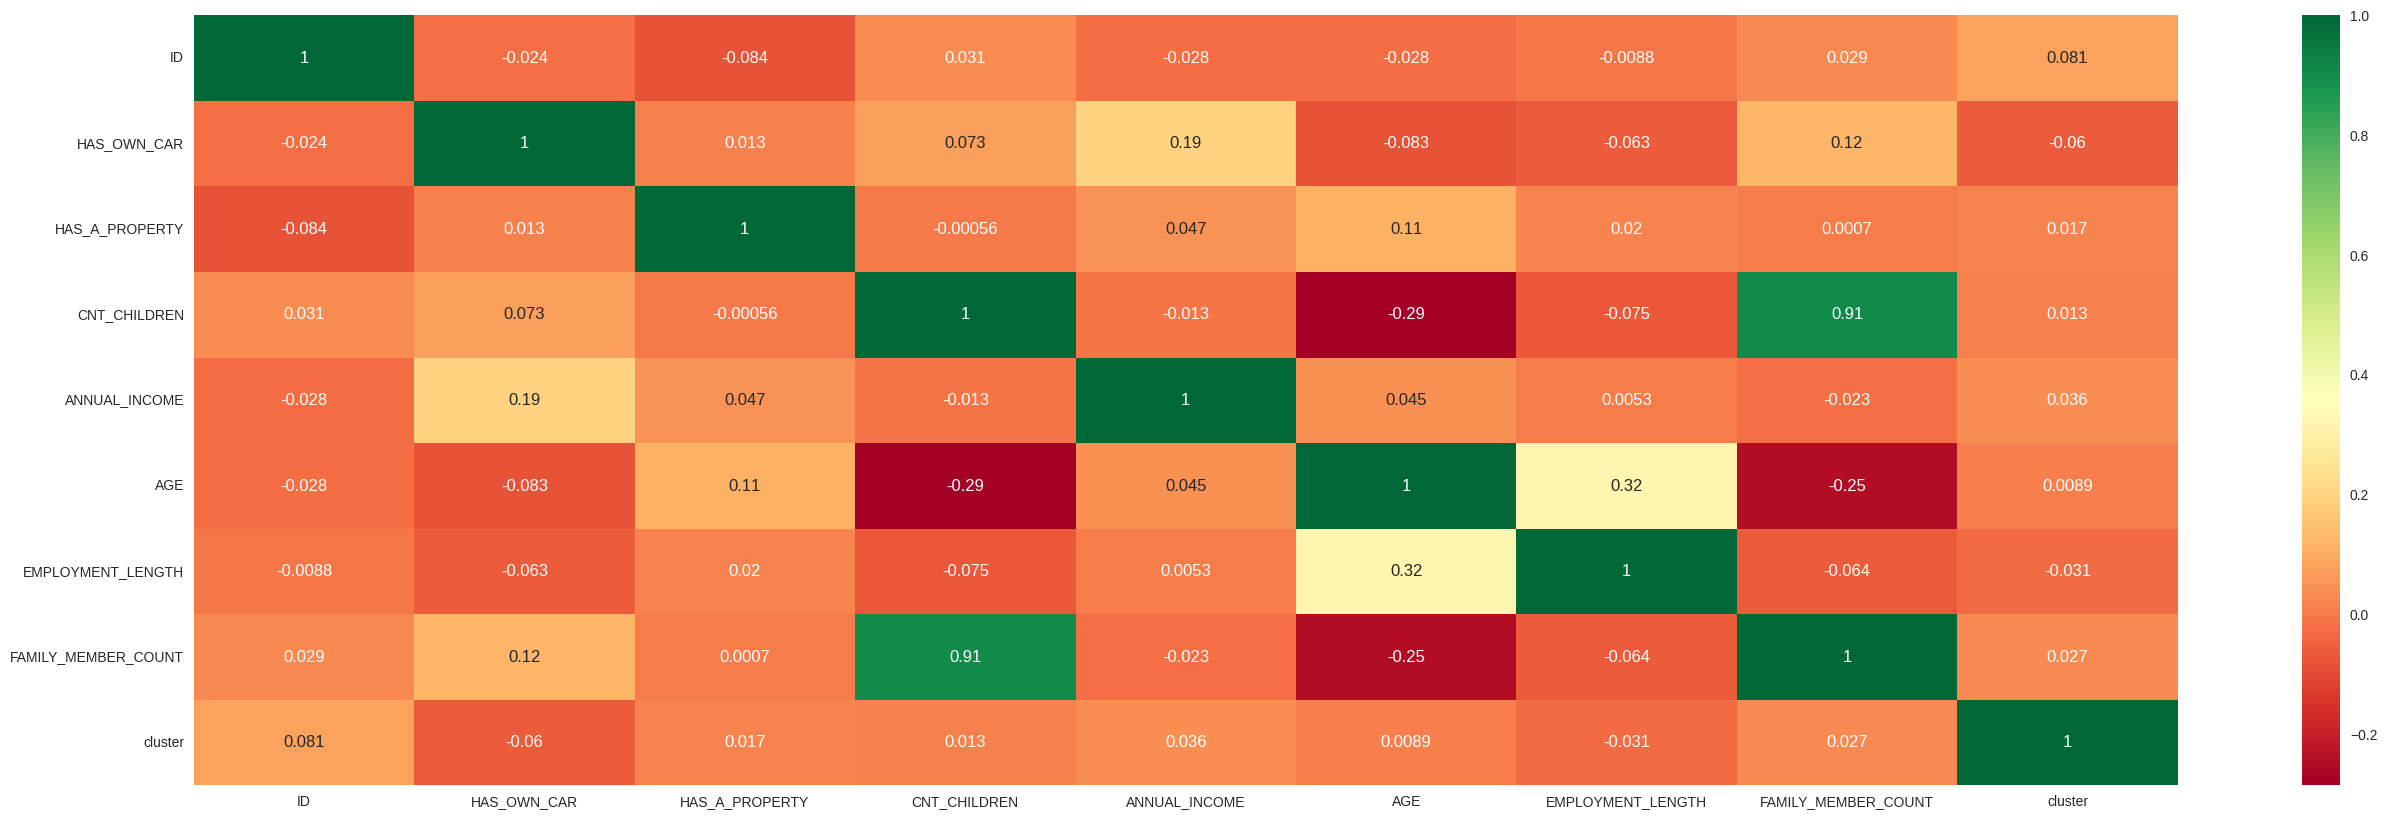

In [106]:
#plt.figure(12,10)
#sns.heatmap(data[df_cluster_new.corr().index].corr(),annot=True,cmap='RdYlGn')
plt.figure(figsize=(32,10))
sns.heatmap(df_cluster_new.corr(),annot=True,cmap='RdYlGn')

## Predicting Model

In [107]:
df_predict = df_cluster_new.copy()

In [108]:
df_predict = pd.get_dummies(df_predict, columns = ['GENDER', 'HAS_OWN_CAR', 'HAS_A_PROPERTY', 'INCOME_CATEGORY', 'EDUCATION_LEVEL', 'MARITAL_STATUS', 'WAY_OF_LIVING'], drop_first = True)

In [109]:
df_predict.head()

,ID,CNT_CHILDREN,ANNUAL_INCOME,AGE,EMPLOYMENT_LENGTH,JOB_TITTLE,FAMILY_MEMBER_COUNT,cluster,GENDER_M,HAS_OWN_CAR_1,...,EDUCATION_LEVEL_Secondary / secondary special,MARITAL_STATUS_Married,MARITAL_STATUS_Separated,MARITAL_STATUS_Single / not married,MARITAL_STATUS_Widow,WAY_OF_LIVING_House / apartment,WAY_OF_LIVING_Municipal apartment,WAY_OF_LIVING_Office apartment,WAY_OF_LIVING_Rented apartment,WAY_OF_LIVING_With parents
0,5008806,0,112500,59,3,Security staff,2,1,1,1,...,1,1,0,0,0,1,0,0,0,0
1,5008810,0,270000,53,8,Sales staff,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0
2,5008811,0,270000,53,8,Sales staff,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0
3,5112956,0,270000,46,2,Accountants,2,0,1,1,...,0,1,0,0,0,1,0,0,0,0
4,5008825,0,130500,29,3,Accountants,2,1,0,1,...,0,1,0,0,0,1,0,0,0,0


In [110]:
df_predict.columns

Index(['ID', 'CNT_CHILDREN', 'ANNUAL_INCOME', 'AGE', 'EMPLOYMENT_LENGTH',
       'JOB_TITTLE', 'FAMILY_MEMBER_COUNT', 'cluster', 'GENDER_M',
       'HAS_OWN_CAR_1', 'HAS_A_PROPERTY_1', 'INCOME_CATEGORY_Pensioner',
       'INCOME_CATEGORY_State servant', 'INCOME_CATEGORY_Student',
       'INCOME_CATEGORY_Working', 'EDUCATION_LEVEL_Higher education',
       'EDUCATION_LEVEL_Incomplete higher', 'EDUCATION_LEVEL_Lower secondary',
       'EDUCATION_LEVEL_Secondary / secondary special',
       'MARITAL_STATUS_Married', 'MARITAL_STATUS_Separated',
       'MARITAL_STATUS_Single / not married', 'MARITAL_STATUS_Widow',
       'WAY_OF_LIVING_House / apartment', 'WAY_OF_LIVING_Municipal apartment',
       'WAY_OF_LIVING_Office apartment', 'WAY_OF_LIVING_Rented apartment',
       'WAY_OF_LIVING_With parents'],
      dtype='object')

In [111]:
from sklearn.ensemble import RandomForestClassifier
x = df_predict.drop("cluster", axis=1)
y = df_predict["cluster"]

In [112]:
#without_sum_full_df  dataset awal combine
approved_ohe = pd.get_dummies(without_sum_full_df)
approved_ohe

,ID,HAS_OWN_CAR,HAS_A_PROPERTY,CNT_CHILDREN,ANNUAL_INCOME,AGE,EMPLOYMENT_LENGTH,FAMILY_MEMBER_COUNT,cluster,GENDER_F,...,JOB_TITTLE_Laborers,JOB_TITTLE_Low-skill Laborers,JOB_TITTLE_Managers,JOB_TITTLE_Medicine staff,JOB_TITTLE_Private service staff,JOB_TITTLE_Realty agents,JOB_TITTLE_Sales staff,JOB_TITTLE_Secretaries,JOB_TITTLE_Security staff,JOB_TITTLE_Waiters/barmen staff
0,5008806,1,1,0,112500,59,3,2,2,0,...,0,0,0,0,0,0,0,0,1,0
1,5008810,0,1,0,270000,53,8,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,5008811,0,1,0,270000,53,8,1,0,1,...,0,0,0,0,0,0,1,0,0,0
3,5112956,1,1,0,270000,46,2,2,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5008825,1,0,0,130500,29,3,2,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11655,5149145,1,1,0,247500,30,9,2,0,0,...,1,0,0,0,0,0,0,0,0,0
11656,5149158,1,1,0,247500,30,9,2,0,0,...,1,0,0,0,0,0,0,0,0,0
11657,5149775,1,1,0,130500,44,26,2,0,1,...,1,0,0,0,0,0,0,0,0,0
11658,5149834,0,1,0,157500,34,3,2,1,1,...,0,0,0,1,0,0,0,0,0,0


<Axes: xlabel='cluster', ylabel='count'>

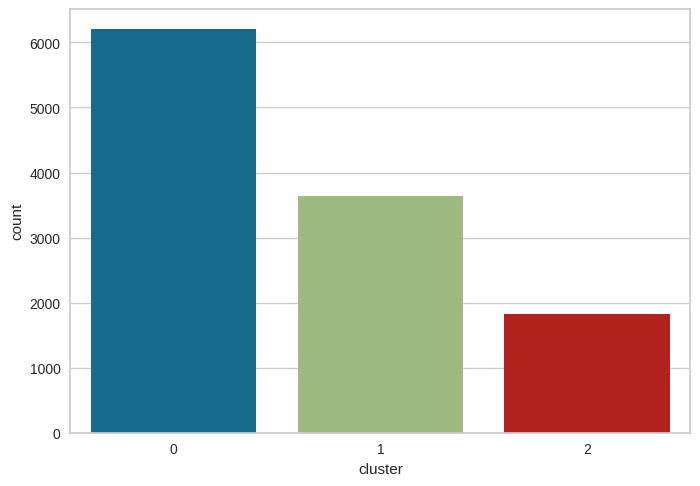

In [113]:
sns.countplot(approved_ohe, x='cluster')

Transform & Split Data For Training
After drawing distribution of the continuous columns data, I decided to apply the log transform of them, except for age to get a more normal distribution

In [114]:
transformed_cols = ['ANNUAL_INCOME', 'FAMILY_MEMBER_COUNT', 'EMPLOYMENT_LENGTH']

for col in transformed_cols:
    without_sum_full_df[col] = without_sum_full_df[col].apply(lambda x: np.log1p(x))

In [115]:
approved_ohe = pd.get_dummies(without_sum_full_df)

X = approved_ohe.drop(columns=['ID','cluster'])
y = approved_ohe['cluster']

In [116]:
mms_cols = ['AGE']
std_cols = ['ANNUAL_INCOME', 'FAMILY_MEMBER_COUNT', 'EMPLOYMENT_LENGTH']

# Create the ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('minmax', MinMaxScaler(), mms_cols),
    ('standard', StandardScaler(), std_cols)
], remainder='passthrough')

# Fit and transform your data using the ColumnTransformer
X_scaled = preprocessor.fit_transform(X)

###Cross Validation
Logistic Regression

In [117]:
def cross_validation(model, X, y, n_splits=5):
    # Create a StratifiedKFold object for stratified cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10)

    # Perform cross-validation with stratified folds
    scores = cross_validate(model, X=X, y=y, cv=cv,
                                scoring=('accuracy', 'precision', 'recall', 'f1'),
                                return_train_score=True)

    avg_fit_time = scores['fit_time'].mean()
    avg_train_accuracy = scores['train_accuracy'].mean()
    avg_test_accuracy = scores['test_accuracy'].mean()
    avg_train_precision = scores['train_precision'].mean()
    avg_test_precision = scores['test_precision'].mean()
    avg_train_recall = scores['train_recall'].mean()
    avg_test_recall = scores['test_recall'].mean()
    avg_train_f1 = scores['train_f1'].mean()
    avg_test_f1 = scores['test_f1'].mean()

    return {
        'average fit time': round(avg_fit_time, 2),
        'train accuracy': round(avg_train_accuracy, 2),
        'test accuracy': round(avg_test_accuracy, 2),
        'train precision': round(avg_train_precision, 2),
        'test precision': round(avg_test_precision, 2),
        'train recall': round(avg_train_recall, 2),
        'test recall': round(avg_test_recall, 2),
        'train f1': round(avg_train_f1, 2),
        'test f1': round(avg_test_f1, 2)
    }

#####Logistic Regression

Logistic Regression is a statistical method used for binary classification, which means it is well-suited for problems with two possible outcomes (typically coded as 0 and 1). Despite its name, logistic regression is used for classification rather than regression. It's called "regression" because it uses a logistic function to model a binary dependent variable.

In [118]:
lr = LogisticRegression()
cross_validation(lr,X_scaled,y, n_splits=5)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign 

{'average fit time': 0.72,
 'train accuracy': 0.53,
 'test accuracy': 0.53,
 'train precision': nan,
 'test precision': nan,
 'train recall': nan,
 'test recall': nan,
 'train f1': nan,
 'test f1': nan}

#####SVC (Support Vector Classification)

SVC stands for "Support Vector Classification," and it refers to a classification method in machine learning that belongs to the Support Vector Machines (SVM) family. SVMs are a type of machine learning model that can be used for classification or regression tasks.

In [119]:
svc = SVC()
cross_validation(svc,X_scaled,y, n_splits=5)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/s

{'average fit time': 7.36,
 'train accuracy': 0.55,
 'test accuracy': 0.54,
 'train precision': nan,
 'test precision': nan,
 'train recall': nan,
 'test recall': nan,
 'train f1': nan,
 'test f1': nan}

#####Random Forest Classifier

Random Forest is an ensemble learning method used for both classification and regression tasks. It is a versatile and powerful machine learning algorithm that operates by constructing a multitude of decision trees at training time and outputs the class that is the mode of the classes (classification) or the mean prediction (regression) of the individual trees.

In [120]:
rdf = RandomForestClassifier()
cross_validation(rdf,X_scaled,y, n_splits=5)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/s

{'average fit time': 1.56,
 'train accuracy': 0.81,
 'test accuracy': 0.6,
 'train precision': nan,
 'test precision': nan,
 'train recall': nan,
 'test recall': nan,
 'train f1': nan,
 'test f1': nan}

#####Catboost Classifier

CatBoost (Categorical Boosting) is a machine learning algorithm specifically designed for categorical feature support. It is a gradient boosting algorithm that belongs to the family of ensemble learning methods. CatBoost is known for its ability to handle categorical features efficiently and its high out-of-the-box performance without extensive hyperparameter tuning.

In [121]:
cb = CatBoostClassifier(verbose=0,)
cross_validation(cb, X_scaled, y, n_splits=5)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/s

{'average fit time': 6.61,
 'train accuracy': 0.72,
 'test accuracy': 0.57,
 'train precision': nan,
 'test precision': nan,
 'train recall': nan,
 'test recall': nan,
 'train f1': nan,
 'test f1': nan}

###Turning For Random Forest Classifier

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=10)
print(X_train.shape)
print(X_test.shape)

(9328, 48)
(2332, 48)


In [123]:
# Fit and transform your data using the ColumnTransformer
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [124]:
rdf = RandomForestClassifier(class_weight='balanced')
rdf.fit(X_train_scaled, y_train)
y_pred = rdf.predict(X_test_scaled)

In [125]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have a model named 'rdf' and scaled features 'X_train_scaled' and 'X_test_scaled'

# Calculate precision, recall, and F1-score for the training set
y_train_pred = rdf.predict(X_train_scaled)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Calculate precision, recall, and F1-score for the test set
y_test_pred = rdf.predict(X_test_scaled)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print the results
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)
print("\nTest Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)


Training Precision: 0.8100318427966485
Training Recall: 0.7958833619210978
Training F1 Score: 0.7988666262291049

Test Precision: 0.5935181870054593
Test Recall: 0.5939108061749572
Test F1 Score: 0.5934089094861974


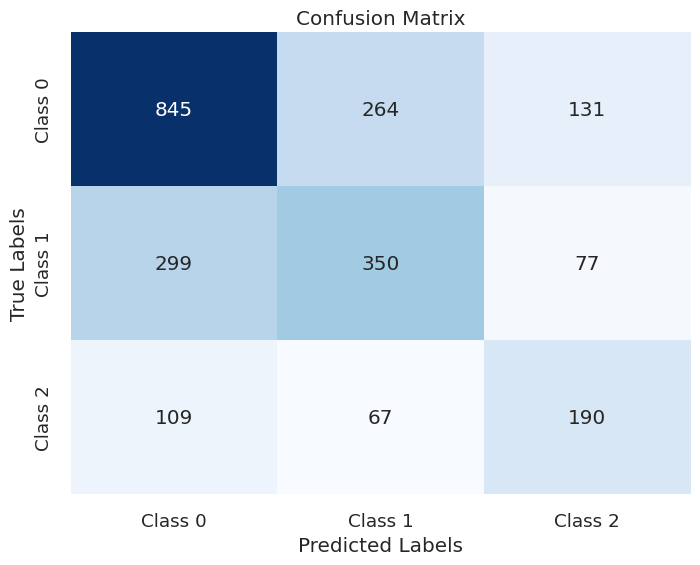

In [126]:
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

True Positive (TP): Misalnya, ada 348 pengamatan yang seharusnya berada di Class 0 dan secara benar diprediksi oleh model sebagai Class 0. Begitu juga untuk kelas 1 (171) dan kelas 2 (796).

False Positive (FP): Misalnya, ada 94 pengamatan yang seharusnya berada di Class 0, tetapi model salah memprediksi sebagai Class 1. Begitu juga untuk kelas 2 (248).

False Negative (FN): Misalnya, ada 61 pengamatan yang seharusnya berada di Class 1, tetapi model salah memprediksi sebagai Class 0. Begitu juga untuk kelas 2 (285).